# PostOpPainGuard™
### Predicting and Optimizing Post-Operative Analgesia in Rabbits Using Synthetic Data and AI

---

# Phase 1 — Project Setup
## Step 1: Project Overview & Rationale


### 1. Research Problem

1. **Concept:** Develop **PostOpGuard**, a predictive framework to identify **rabbits at risk of requiring additional analgesics post-surgery** across multiple surgical procedures.  
2. **Objective:** Compute an **AnalgesiaNeedScore (0–100)** to guide **timely clinical intervention within 24 hours post-operatively**.  
3. **Scope:** Uses only **demographic, surgical, anesthetic, and pre-operative clinical features**, without video or invasive telemetry.  
4. **Ethical Compliance:** Aligned with **AAALAC, IACUC, and 3Rs principles**, emphasizing **refinement, non-invasive monitoring, and actionable welfare outcomes**.  

![Rabbit illustration](https://www.understandinganimalresearch.org.uk/application/files/thumbnails/page_2x/1117/3859/9073/Rab_5-min.png)  
*Image courtesy of [Understanding Animal Research](https://www.understandinganimalresearch.org.uk/using-animals-in-scientific-research/animal-research-species/rabbit)*

---

### 2. Context & Background

- Previous video-based deep learning achieved ~87% accuracy for rabbit post-operative pain ([Feighelstein et al., 2023](https://www.nature.com/articles/s41598-023-41774-2)).  
  - These video-based systems represent significant progress in automated pain assessment but rely on high-quality imaging, controlled lighting, and complex setups, which can limit scalability, reproducibility, and cross-species adaptation.  

- **PostOpGuard Advantages:**  
  - **Ethical & 3Rs-Aligned:** Uses fully synthetic, structured data to model post-operative analgesia needs — eliminating live-animal data collection and reinforcing the principles of Replacement, Reduction, and Refinement.  
  - **Structured Clinical Modeling:** Relies on routinely recorded demographic, anesthetic, and surgical features, making the framework practical and compatible with standard laboratory workflows.  
  - **Interpretability & Transparency:** Each prediction can be traced to physiological and procedural factors (e.g., duration, grimace, analgesic dose), ensuring transparency and clinical relevance.  
  - **Scalability & Adaptability:** Easily extends to multiple surgery types and other species (rats, mice, zebrafish) without requiring specialized imaging or additional animal use. 
  - **Complementary to Prior Research:** Builds on video-based advances by providing an alternative, ethically enhanced modeling strategy that focuses on structured data and explainable AI for clinical decision support.  

**Synthetic Data Simulation:**  
- Generated because real post-operative rabbit datasets are unavailable.  
- Simulates a **complete laboratory environment**: 5,000 rabbits, 5 surgery types, 10 veterinarians (VetID).  
- Incorporates **inter-observer variability, missing data, and rare high-pain events**.  
- Preserves **plausible age, weight, pain, analgesic, and pre-op distributions**.  
- **Reproducibility:** Random seeds and controlled noise ensure consistent simulation outcomes.  
- Supports **robust model training, validation, and reproducibility** while **minimizing live animal use**.

---

### 3. Importance of Multi-Surgery Modeling

- Pain differs across **SurgeryType**: Ovariohysterectomy, Castration, BoneDefect, Catheterization, OcularImplant.  
- Multi-surgery inclusion ensures:  
  - **Better model generalization**  
  - **Per-procedure evaluation**  
  - Capture of **realistic variability** across procedures and vets  

---

### 4. Ethical & Regulatory Considerations

- All datasets comply with **animal welfare regulations**.  
- **IACUC Alignment:** Predictions support, not replace, **veterinary decisions**.  
- **3Rs Principles:**  
  - **Reduction:** Minimize exploratory animal testing  
  - **Refinement:** Improve analgesia prediction accuracy  
  - **Replacement:** Reduce live animal use  
- Outputs are **auditable**, logging scores and top contributing features.

---

### 5. Species Context & Adaptability

- **Species-Adaptable Framework:** Can be adapted to rats, mice, or zebrafish with adjustments.  
- **Why Rabbits:**  
  - Common in ocular, orthopedic, reproductive, and pharmacological research  
  - Validated pain metrics: grimace scales, behavior scoring, and physiological markers  
  - Moderate size and known metabolism allow reproducible procedures and accurate analgesic dosing  
  - Multi-surgery spectrum captures low- to high-pain events  
  - Predictive outputs are interpretable for veterinary practice  

**Key Takeaway:**  
Rabbits provide a **robust, ethically justifiable model** for PostOpGuard. The synthetic lab simulation, including vets and inter-animal variability, enables **high-fidelity, interpretable, and reproducible ML model development**. Simulation preserves critical clinical patterns, supporting robust model training and future species adaptation.


## Phase 1 — Step 2: Import Libraries

#### Core Libraries
- **numpy, pandas** — numerical computation & data management  

#### Visualization
- **matplotlib, seaborn** — exploratory visualization & plots  

#### Modeling
- **scikit-learn:** LogisticRegression, LassoCV, RandomForest, GradientBoosting, HistGradientBoosting  
- **xgboost / lightgbm** — advanced gradient boosting algorithms  
- **mord (LogisticAT)** — ordinal logistic regression  

#### Stats & Diagnostics
- **statsmodels (VIF)** — multicollinearity checks  
- **scikit-learn (StandardScaler, LabelEncoder)** — preprocessing  

#### Explainability
- **shap** — feature contribution & model interpretability  

#### Utilities
- **joblib, os, warnings, missingno** — model persistence, system utilities, warning control, missing data visualization  



In [3]:
# ================================
# PostOpGuard — Library Imports
# ================================

# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor
)
from sklearn.model_selection import (
    train_test_split,
    KFold,
    GroupKFold,
    cross_val_score
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    r2_score,
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Specialized Models
import xgboost as xgb
import lightgbm as lgb
from mord import LogisticAT  # Ordinal Logistic Regression

# Stats & Feature Diagnostics
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Explainability
import shap

# Utilities
import joblib
import os
import warnings
import missingno as msno

# Settings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

print("All libraries imported successfully ✅")

All libraries imported successfully ✅


# Phase 2 — Step 1: Dataset Generation

## Objectives

- Generate a **fully synthetic rabbit surgical dataset** that simulates an **entire laboratory environment** with multiple veterinarians and surgical procedures.  
- Encode **procedure-specific age, weight, and expected pain distributions** based on veterinary knowledge.  
- Model **latent analgesia need** incorporating:
  - Surgery duration normalized by weight  
  - Pre-operative grimace and behavior scores  
  - Physiological biomarker baselines  
  - Local anesthetic blocks  
  - Intra-operative analgesics  
  - Veterinarian-specific variability (inter-observer bias)  
- Produce both **continuous outcomes** (`AnalgesiaNeedScore`) and **categorical outcomes** (`AnalgesiaNeedCategory`) to support regression and classification tasks in ML.  
- **Preserve rare high-pain events** to ensure ML models adequately learn these critical, low-frequency outcomes.  

---

## Key Features & Rationale

### Demographics & Physiology
- `AgeWeeks`, `WeightKg`, `Sex`, `Strain` capture realistic animal variability.

### Surgery-Specific Variables
- `SurgeryType`, `SurgeryPainBoost`, and `DurationPerKg` encode expected procedural pain and physiological load.

### Pre-Operative Pain Indicators
- `PreOpGrimace`, `PreOpBehaviorScore`, `PreOpBiomarker`, and derived `PreOpRiskScore` quantify baseline pain risk.

### Interventions
- `LocalBlock` and `IntraOpAnalgesicMgPerKg` simulate analgesic interventions that reduce pain.

### Observer Effects
- `VetID` and `VetBias` introduce realistic inter-observer variability, reflecting how different veterinarians perceive and score pain.

### Outcome Variables
- `AnalgesiaNeedScore` (0–100) and `AnalgesiaNeedCategory` (Low/Medium/High) are primary endpoints.  
- Secondary clinically meaningful variables such as `FirstPostOpGrimace` and `RescueAnalgesiaGiven` are included for potential validation.

---

## Veterinary Rationale

- Reflects **real-world laboratory variability** in rabbit surgery outcomes.  
- Ensures ML models learn **biologically meaningful relationships** between surgical features, interventions, and pain outcomes.  
- Maintains **rare but clinically important high-pain events**, critical for ethical and treatment considerations.  
- Models **inter-observer differences** to simulate real laboratory assessment noise.  
- Differentiates procedures such as **catheter insertions (low pain)** vs **bone defects (high pain)** in line with veterinary practice.

---

## ML Rationale

- Comprehensive feature set and engineered interactions (e.g., `DurationPerKg_x_PreOpGrimace`) reduce **underfitting risk**.  
- Continuous scores enable **regression tasks**; categorical scores support **classification** of pain severity.  
- Balanced dataset across pain categories improves **model stability**.  
- Incorporating **vet-specific bias** and biological noise enhances **generalization** to unseen rabbits and procedures.

---

## Limitations & Considerations

### Surgical Modeling
- **Complications not explicitly modeled**: Each procedure is represented with a controlled baseline plus light variability.  
- **Pain duration simplified**: Fixed per-surgery mean with small noise; real-world recovery may vary more.  
- **Single-level complexity modifier**: Only a binary "Minor/Major" adjustment is applied; finer granularity is not modeled.

### Biological Factors
- **Strain effects minimal**: Small differences maintain model robustness without dominating latent pain calculation.  
- **Limited biomarker scope**: Only one synthetic biomarker is included; real assessments may include multiple stress or inflammatory markers.

### Dataset Scope
- **Synthetic-only**: While biologically informed, this dataset does not replace real experimental data. Serves as a proof-of-concept for ML modeling and methodology testing.

---

## Outcome

A **synthetic, biologically plausible rabbit surgery dataset** simulating:

- Multiple veterinarians  
- A variety of surgical procedures  
- Pre- and intra-operative interventions  
- Latent pain outcomes  

Ready for:

- Feature engineering  
- Machine learning modeling & prediction  
- Validation and interpretability studies

**Key Takeaway:**  
This dataset balances **biological fidelity** with **ML usability**, replicating a realistic laboratory environment while preserving **clinically meaningful patterns** for robust and generalizable model training.  
It explicitly models both **rabbits and vets**, making it suitable for advanced **grouped analyses** and **explainable AI studies**.


In [5]:
# -----------------------------
# Phase 2 — Step 1: Dataset Generation (Fixed VetID & bias)
# -----------------------------

np.random.seed(42)

# Parameters
n_rabbits = 5000
surgery_types = ['Ovariohysterectomy', 'Castration', 'BoneDefect', 'Catheter', 'OcularImplant']
sexes = ['Male', 'Female']

# Real-world common lab rabbit strains
strains = ['New Zealand White', 'Dutch Belted', 'Californian']

anesthesia_protocols = ['Protocol1', 'Protocol2']
housing_types = ['Single', 'Group']
vet_list = [f'Vet{i}' for i in range(1, 11)]   # Keep original list intact

# Surgery-specific ranges
age_ranges = {
    'Ovariohysterectomy': (16, 40),
    'Castration': (16, 40),
    'BoneDefect': (12, 52),
    'Catheter': (8, 48),
    'OcularImplant': (12, 48)
}
weight_ranges = {
    'Ovariohysterectomy': (2.0, 5.0),
    'Castration': (2.0, 5.0),
    'BoneDefect': (1.5, 6.0),
    'Catheter': (1.0, 4.0),
    'OcularImplant': (1.5, 5.0)
}
duration_ranges = {
    'Catheter': (15, 60),
    'Castration': (10, 30),
    'Ovariohysterectomy': (40, 120),
    'OcularImplant': (60, 150),
    'BoneDefect': (90, 180)
}

surgery_pain_boost = {
    'Catheter': 1.5,
    'Castration': 5.5,
    'Ovariohysterectomy': 8,
    'OcularImplant': 10,
    'BoneDefect': 12
}

expected_pain_duration = {
    'Catheter': 1,
    'Castration': 2,
    'Ovariohysterectomy': 4,
    'OcularImplant': 5,
    'BoneDefect': 7
}

# Strain modifiers
strain_weight_offset = {
    'New Zealand White': 0.5,
    'Dutch Belted': -0.4,
    'Californian': 0.0
}
strain_biomarker_shift = {
    'New Zealand White': -1.0,
    'Dutch Belted': 2.0,
    'Californian': 0.0
}
strain_pain_multiplier = {
    'New Zealand White': -0.05,
    'Dutch Belted': 0.08,
    'Californian': 0.0
}

# Generate dataset
records = []
for i in range(n_rabbits):
    surgery = np.random.choice(surgery_types)
    strain = np.random.choice(strains)
    
    # Sex linked to surgery
    if surgery == 'Castration':
        sex = 'Male'
    elif surgery == 'Ovariohysterectomy':
        sex = 'Female'
    else:
        sex = np.random.choice(sexes)
    
    age = np.random.randint(*age_ranges[surgery])
    
    base_weight = np.round(np.random.uniform(*weight_ranges[surgery]), 2)
    weight = np.round(base_weight + strain_weight_offset[strain], 2)
    min_w = max(0.6, weight_ranges[surgery][0] * 0.8)
    max_w = weight_ranges[surgery][1] * 1.2
    weight = float(np.clip(weight, min_w, max_w))
    
    duration = np.random.randint(*duration_ranges[surgery])
    
    local_block = np.random.choice([0,1], p=[0.7,0.3])
    
    # Intra-op analgesics
    analgesic_ranges = {
        'Buprenorphine': (0.01, 0.05),
        'Meloxicam': (0.3, 0.6),
        'Fentanyl': (0.005, 0.01),
        'Carprofen': (2, 4),
        'Ketoprofen': (1, 3)
    }
    drug_potency = {
        'Buprenorphine': 1.0,
        'Meloxicam': 0.8,
        'Fentanyl': 3.0,
        'Carprofen': 0.7,
        'Ketoprofen': 0.6
    }
    
    n_drugs = np.random.choice([1,2], p=[0.8,0.2])
    
    if surgery in ['BoneDefect','OcularImplant','Ovariohysterectomy']:
        probs = [0.2,0.2,0.3,0.2,0.1]
    else:
        probs = [0.4,0.3,0.1,0.1,0.1]
    
    selected_drugs = np.random.choice(list(analgesic_ranges.keys()), size=n_drugs, replace=False, p=probs)
    
    intra_op_analgesic = 0
    for drug in selected_drugs:
        dose = np.round(np.random.uniform(*analgesic_ranges[drug]), 3)
        dose *= np.random.uniform(0.95, 1.05)
        intra_op_analgesic += dose * drug_potency[drug]
    
    pre_grimace = np.random.randint(0,6)
    pre_behavior = np.random.randint(0,6)
    pre_biomarker = np.round(np.random.normal(50 + strain_biomarker_shift[strain], 10), 2)
    
    vet = np.random.choice(vet_list)
    vet_bias = np.random.normal(0, 0.5)
    
    complexity = 1.5 if surgery in ['BoneDefect','Ovariohysterectomy','OcularImplant'] else 1.0
    
    pre_grimace_term = 5.0 * np.sqrt(pre_grimace + 1) * (1.0 + strain_pain_multiplier[strain])
    
    latent_pain = (
        3.0*(weight**-0.5)*np.log(1 + age) +
        pre_grimace_term +
        0.5*pre_biomarker +
        surgery_pain_boost[surgery] * complexity -
        1.5*local_block * complexity -
        1.2*intra_op_analgesic +
        vet_bias +
        np.random.normal(0, 1 + 0.05*surgery_pain_boost[surgery])
    )
    
    pain_duration = max(
        1,
        expected_pain_duration[surgery] + np.random.randint(-1, 3)
    )
    
    records.append({
        'RabbitID': i+1,
        'SurgeryID': np.random.randint(1000,9999),
        'AgeWeeks': age,
        'WeightKg': weight,
        'Sex': sex,
        'Strain': strain,
        'SurgeryType': surgery,
        'DurationMin': duration,
        'AnesthesiaProtocol': np.random.choice(anesthesia_protocols),
        'LocalBlock': local_block,
        'IntraOpAnalgesicMgPerKg': intra_op_analgesic,
        'PreOpGrimace': pre_grimace,
        'PreOpBehaviorScore': pre_behavior,
        'PreOpBiomarker': pre_biomarker,
        'Housing': np.random.choice(housing_types),
        'VetID': vet,
        'SurgeryPainBoost': surgery_pain_boost[surgery],
        'LatentPain': latent_pain,
        'ExpectedPainDurationDays': pain_duration
    })

df = pd.DataFrame(records)

# Introduce realistic missingness
df.loc[df.sample(frac=0.1).index, 'PreOpBiomarker'] = np.nan
df.loc[df.sample(frac=0.05).index, 'PreOpGrimace'] = np.nan

df

,RabbitID,SurgeryID,AgeWeeks,WeightKg,Sex,Strain,SurgeryType,DurationMin,AnesthesiaProtocol,LocalBlock,IntraOpAnalgesicMgPerKg,PreOpGrimace,PreOpBehaviorScore,PreOpBiomarker,Housing,VetID,SurgeryPainBoost,LatentPain,ExpectedPainDurationDays
0,1,9666,15,3.30,Male,New Zealand White,Catheter,53,Protocol1,0,0.308572,2.0,5,NaN,Single,Vet6,1.5,40.328033,1
1,2,7235,30,3.86,Male,Californian,Castration,21,Protocol1,0,0.032880,1.0,3,65.39,Group,Vet9,5.5,49.797944,4
2,3,7439,42,4.23,Female,New Zealand White,Catheter,50,Protocol1,0,0.291561,4.0,1,51.19,Group,Vet8,1.5,44.138052,1
3,4,6892,35,2.35,Male,Dutch Belted,OcularImplant,119,Protocol2,0,1.577542,0.0,3,78.56,Single,Vet8,10.0,66.712259,4
4,5,7938,22,5.05,Male,New Zealand White,Castration,21,Protocol1,0,0.023528,5.0,2,28.56,Single,Vet3,5.5,36.568192,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,5055,23,0.85,Male,Dutch Belted,Catheter,35,Protocol1,1,0.016381,2.0,5,56.01,Group,Vet8,1.5,47.362443,2
4996,4997,5457,31,3.58,Male,Dutch Belted,Castration,23,Protocol1,1,1.370893,2.0,5,52.47,Group,Vet1,5.5,42.732277,1
4997,4998,1815,27,3.51,Male,Californian,OcularImplant,127,Protocol2,1,0.018685,4.0,5,40.35,Group,Vet5,10.0,50.583937,5
4998,4999,3569,23,4.49,Male,Californian,Castration,12,Protocol2,1,0.031734,2.0,0,60.49,Group,Vet5,5.5,48.539669,2


## Phase 2 — Step 2: Data Quality Checks & Imputation 

**Objectives:**
1. Validate realistic ranges for critical features:
   - **WeightKg:** 1–5 kg
   - **DurationMin:** 20–180 min
   - **IntraOpAnalgesicMgPerKg:** 0–5 mg/kg
2. Identify and clip extreme/out-of-range values
3. Visualize missingness:
   - **Matrix plot** to show missing data patterns per rabbit
   - **Bar plot** to show counts of missing/non-missing values per feature
4. Impute missing values:
   - **Median** for numeric features (`PreOpGrimace`, `PreOpBehaviorScore`, `PreOpBiomarker`) stratified by `SurgeryType`
   - **Mode** for categorical features (`LocalBlock`, `Housing`, `AnesthesiaProtocol`)
5. Compute derived features:
   - `DurationPerKg`, `PreOpGrimaceFilled`, `PreOpBiomarkerFilled`, `PreOpRiskScore`, `SurgeryComplexity`
6. Map latent pain to `AnalgesiaNeedScore` (0–100) and categorize into `Low`, `Medium`, `High`
7. Generate first post-op grimace score and probabilistic `RescueAnalgesiaGiven`
8. Oversample **High-pain events** to balance classes with Medium pain

---

### Veterinary Rationale:
- Ensures synthetic dataset reflects realistic rabbit physiology, strain differences, and surgical procedures  
- Detects errors and impossible values that could mislead ML models  
- Balances pain categories to improve sensitivity to high-pain cases

---

### ML Rationale:
- Clipping extreme values prevents models from learning artifacts  
- Imputation preserves sample size and reduces bias  
- Derived features enhance model input without introducing leakage  
- Class balancing reduces imbalance, improving prediction for rare high-pain events



In [7]:
# -----------------------------
# Phase 2 — Step 2: Data Quality Checks & Imputation (Enhanced)
# -----------------------------

# 1️⃣ Clip extreme values to biologically plausible ranges
df['WeightKg'] = df['WeightKg'].clip(1.0, 5.0)
df['DurationMin'] = df['DurationMin'].clip(20, 180)
df['IntraOpAnalgesicMgPerKg'] = df['IntraOpAnalgesicMgPerKg'].clip(0.0, 5.0)

out_of_range_count = (
    (df['WeightKg'] < 1) | (df['WeightKg'] > 5) |
    (df['DurationMin'] < 20) | (df['DurationMin'] > 180) |
    (df['IntraOpAnalgesicMgPerKg'] < 0) | (df['IntraOpAnalgesicMgPerKg'] > 5)
).sum()
print(f"Number of out-of-range values after clipping: {out_of_range_count}")

Number of out-of-range values after clipping: 0


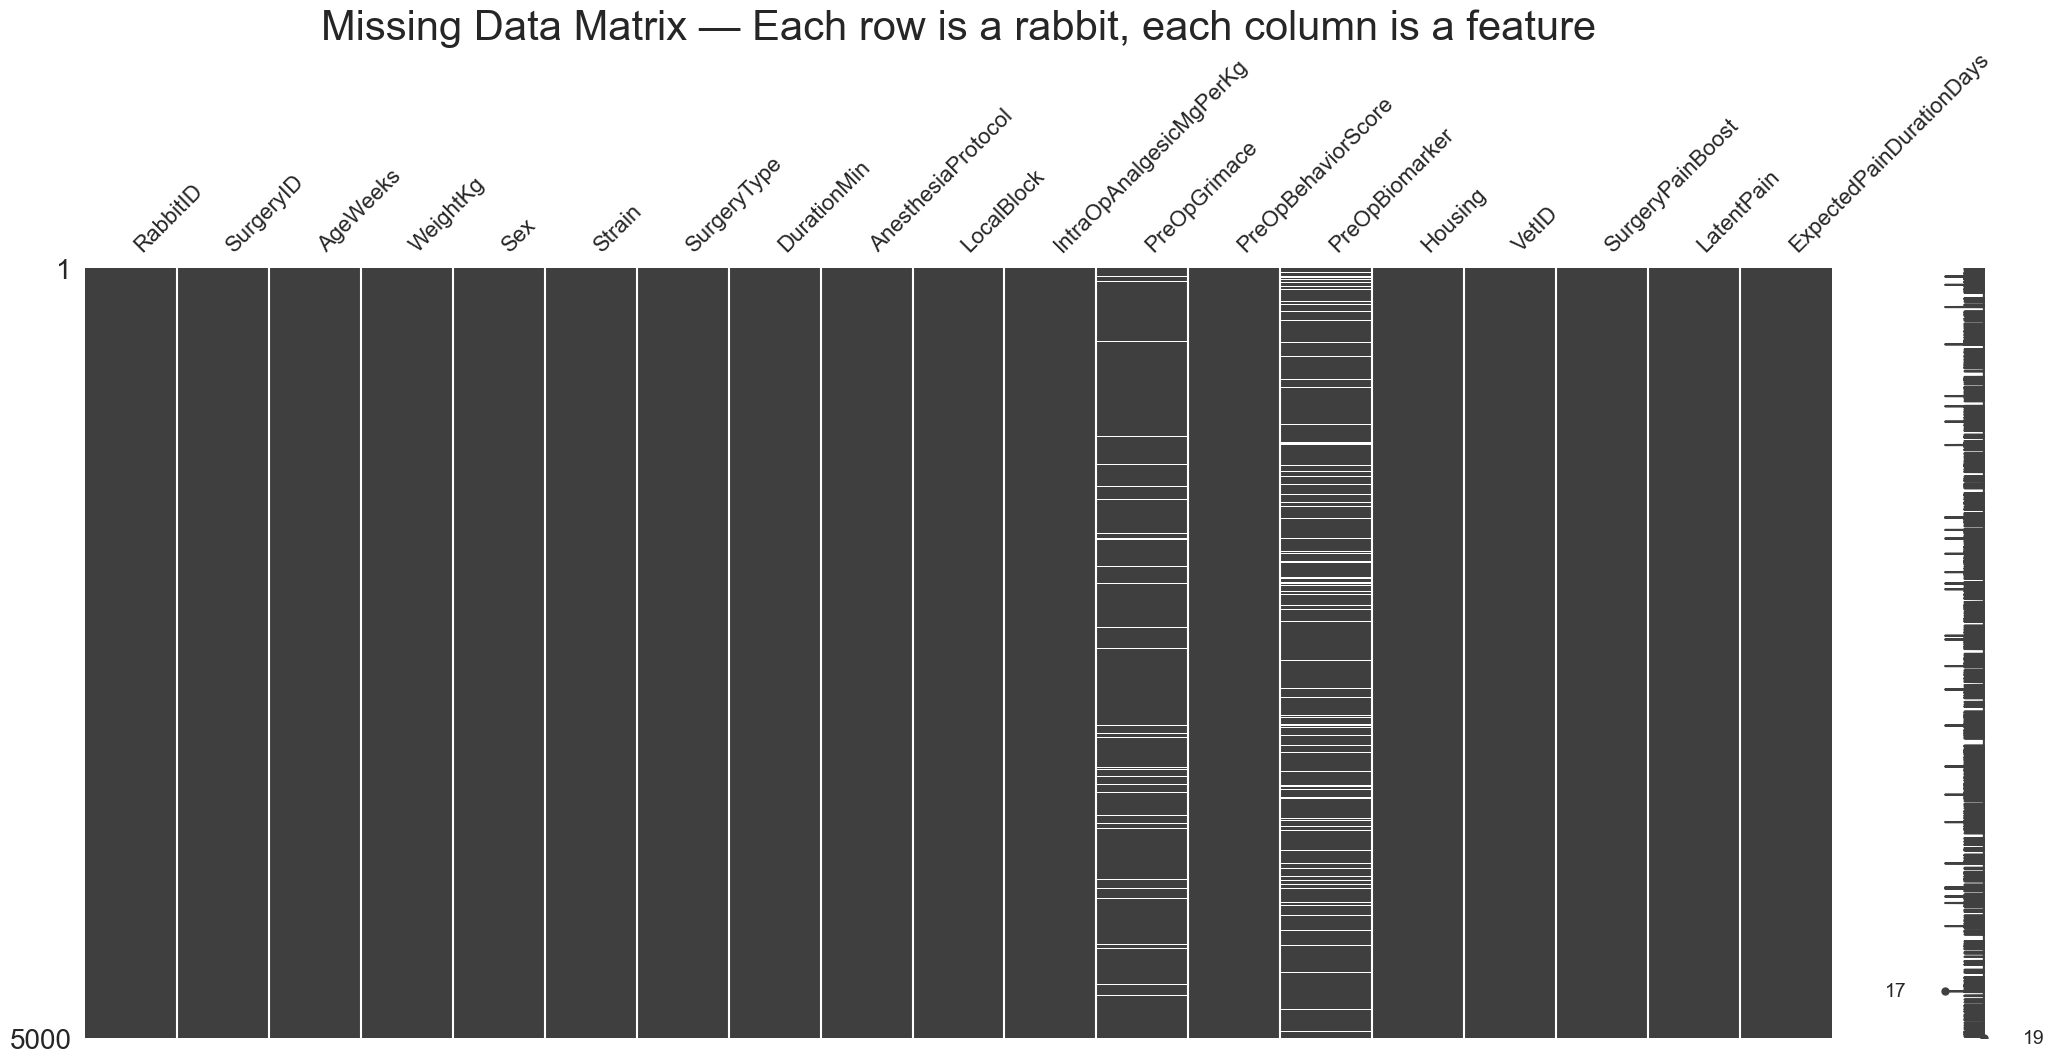

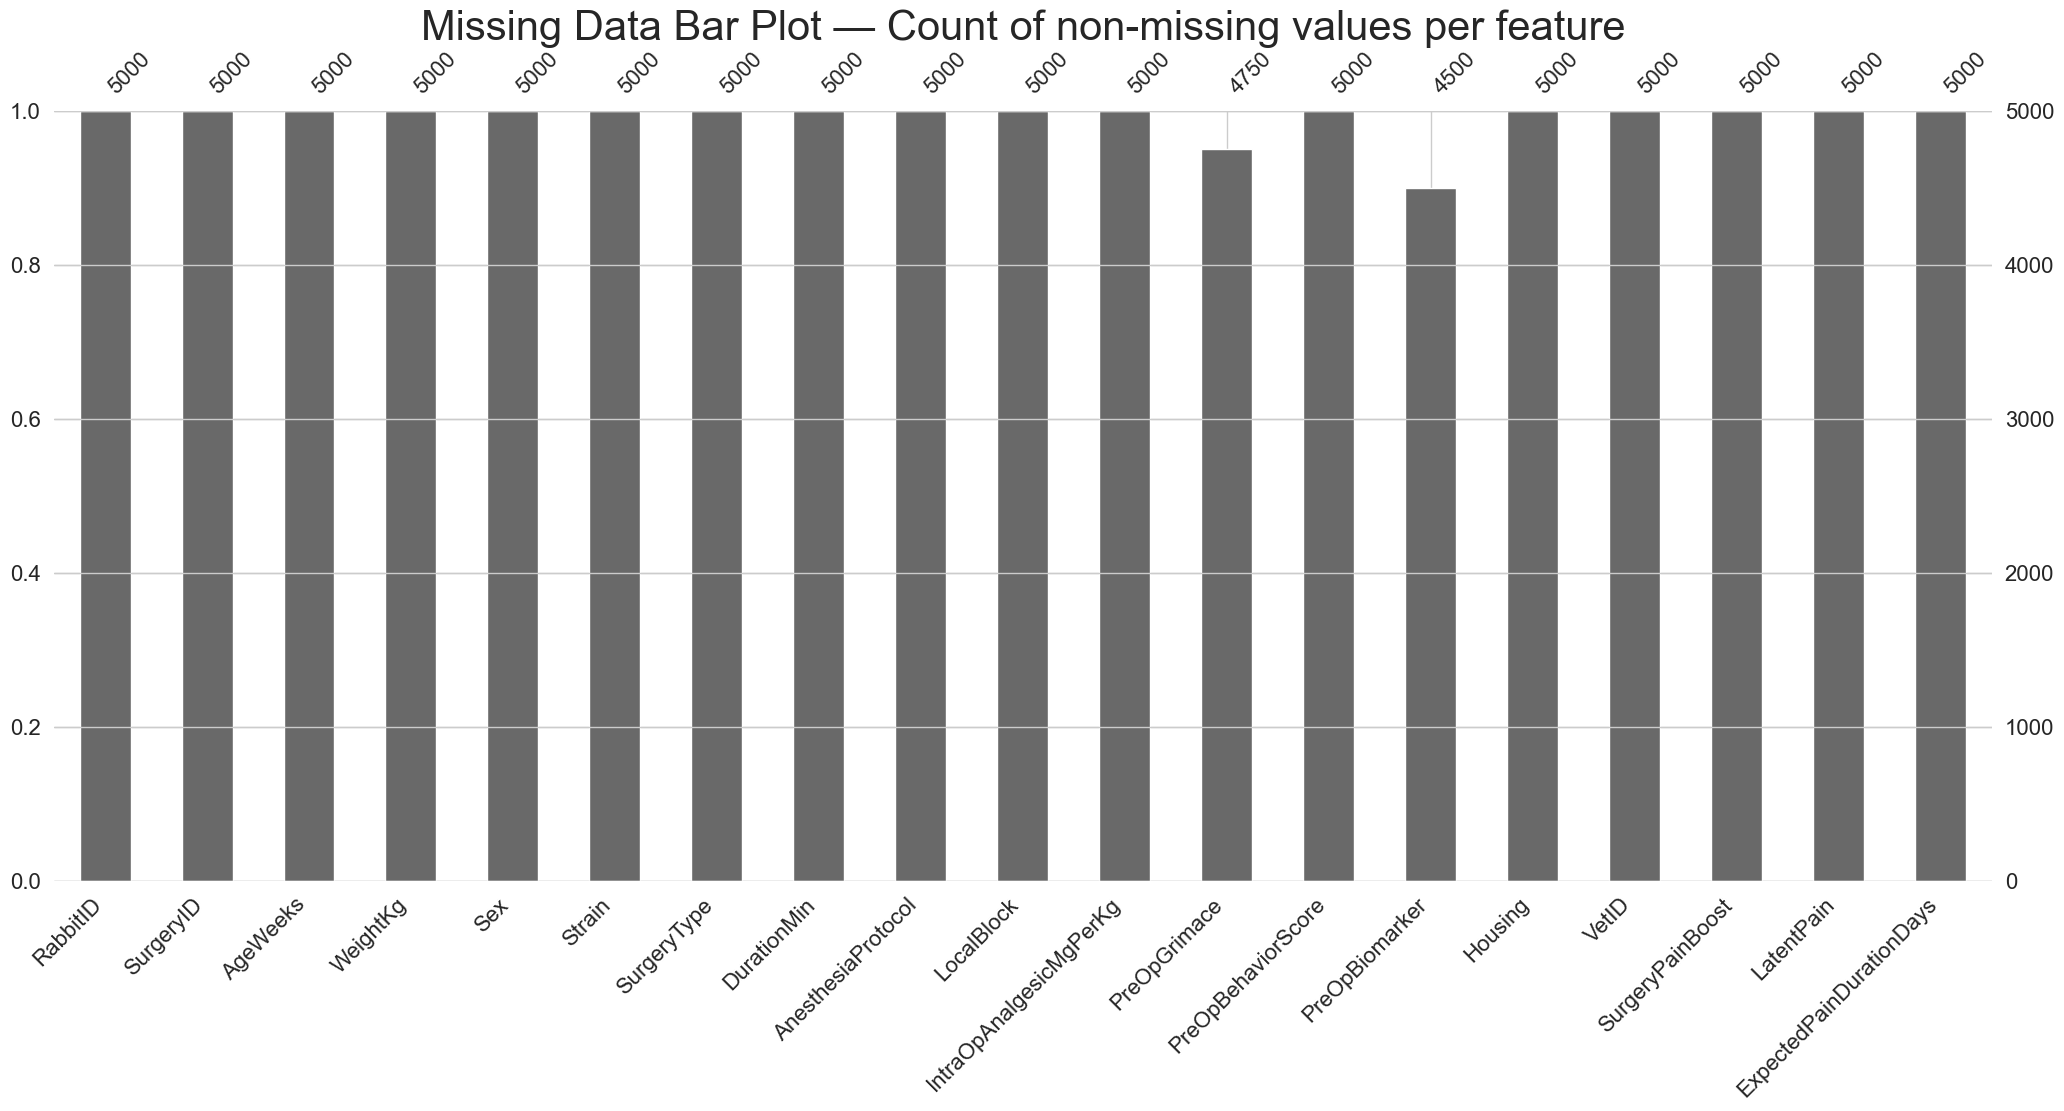

In [8]:
# 2️⃣ Visualize missingness
msno.matrix(df)
plt.title("Missing Data Matrix — Each row is a rabbit, each column is a feature", fontsize=30)
plt.show()

print('\n' + '='*60 + '\n')

msno.bar(df)
plt.title("Missing Data Bar Plot — Count of non-missing values per feature", fontsize=30)
plt.show()

In [9]:
# 3️⃣ Imputation for missing values
numeric_cols = ['PreOpGrimace', 'PreOpBehaviorScore', 'PreOpBiomarker']
categorical_cols = ['LocalBlock', 'Housing', 'AnesthesiaProtocol']

# Numeric: stratified by SurgeryType
for col in numeric_cols:
    df[col] = df.groupby('SurgeryType')[col].transform(lambda x: x.fillna(x.median()))

# Categorical: fill with mode
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# 4️⃣ Derived features (after imputation)
df['DurationPerKg'] = df['DurationMin'] / df['WeightKg']
df['PreOpGrimaceFilled'] = df['PreOpGrimace']
df['PreOpBiomarkerFilled'] = df['PreOpBiomarker']
df['PreOpRiskScore'] = df['PreOpGrimaceFilled'] + df['PreOpBiomarkerFilled']/10
df['SurgeryComplexity'] = df['SurgeryType'].apply(
    lambda x: 'Major' if x in ['BoneDefect','Ovariohysterectomy','OcularImplant'] else 'Minor'
)

# 5️⃣ Map latent pain → 0–100 AnalgesiaNeedScore
df['AnalgesiaNeedScore'] = np.clip(
    (df['LatentPain'] - df['LatentPain'].min()) / 
    (df['LatentPain'].max() - df['LatentPain'].min()) * 100, 0, 100
)

# Categorize pain levels
def categorize_pain(score):
    if score < 35: return 'Low'
    elif score < 70: return 'Medium'
    else: return 'High'

df['AnalgesiaNeedCategory'] = df['AnalgesiaNeedScore'].apply(categorize_pain)

# 6️⃣ First post-op grimace (±1–2 points, clipped 0–5)
df['FirstPostOpGrimace'] = np.clip(
    df['PreOpGrimaceFilled'] + np.random.randint(-2,3,len(df)), 0, 5
)

# 7️⃣ Rescue analgesia probabilistic for Medium/High pain
df['RescueAnalgesiaGiven'] = df['AnalgesiaNeedCategory'].apply(
    lambda x: 1 if x=='High' else (np.random.rand()<0.15 if x=='Medium' else 0)
)

# 8️⃣ Check distribution before balancing
print("AnalgesiaNeedCategory distribution before balancing:\n", df['AnalgesiaNeedCategory'].value_counts())

# 9️⃣ Oversample High-pain events to match Medium class
counts = df['AnalgesiaNeedCategory'].value_counts()
high_needed = counts['Medium'] - counts['High']
if high_needed > 0:
    high_pain = df[df['AnalgesiaNeedCategory']=='High']
    df_balanced = pd.concat([df, high_pain.sample(n=high_needed, replace=True)], axis=0)
else:
    df_balanced = df.copy()

df_balanced.reset_index(drop=True, inplace=True)

# 10️⃣ Confirm new distribution
print("AnalgesiaNeedCategory distribution after balancing:\n", df_balanced['AnalgesiaNeedCategory'].value_counts())

# Dataset ready
df_balanced

AnalgesiaNeedCategory distribution before balancing:
 AnalgesiaNeedCategory
Medium    3697
High       778
Low        525
Name: count, dtype: int64
AnalgesiaNeedCategory distribution after balancing:
 AnalgesiaNeedCategory
Medium    3697
High      3697
Low        525
Name: count, dtype: int64


,RabbitID,SurgeryID,AgeWeeks,WeightKg,Sex,Strain,SurgeryType,DurationMin,AnesthesiaProtocol,LocalBlock,...,ExpectedPainDurationDays,DurationPerKg,PreOpGrimaceFilled,PreOpBiomarkerFilled,PreOpRiskScore,SurgeryComplexity,AnalgesiaNeedScore,AnalgesiaNeedCategory,FirstPostOpGrimace,RescueAnalgesiaGiven
0,1,9666,15,3.30,Male,New Zealand White,Catheter,53,Protocol1,0,...,1,16.060606,2.0,50.08,7.008,Minor,39.313410,Medium,3.0,False
1,2,7235,30,3.86,Male,Californian,Castration,21,Protocol1,0,...,4,5.440415,1.0,65.39,7.539,Minor,55.779155,Medium,0.0,False
2,3,7439,42,4.23,Female,New Zealand White,Catheter,50,Protocol1,0,...,1,11.820331,4.0,51.19,9.119,Minor,45.938056,Medium,2.0,False
3,4,6892,35,2.35,Male,Dutch Belted,OcularImplant,119,Protocol2,0,...,4,50.638298,0.0,78.56,7.856,Major,85.188811,High,0.0,1
4,5,7938,22,5.00,Male,New Zealand White,Castration,21,Protocol1,0,...,3,4.200000,5.0,28.56,7.856,Minor,32.776011,Low,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7914,4795,7079,25,3.19,Male,Dutch Belted,BoneDefect,112,Protocol2,0,...,8,35.109718,3.0,57.02,8.702,Major,75.697137,High,2.0,1
7915,4582,4301,40,4.33,Female,Dutch Belted,OcularImplant,77,Protocol1,0,...,5,17.782910,4.0,62.30,10.230,Major,83.048660,High,5.0,1
7916,2964,1326,28,4.27,Male,Californian,OcularImplant,137,Protocol1,0,...,6,32.084309,4.0,60.41,10.041,Major,72.701738,High,5.0,1
7917,4554,8817,16,2.61,Female,Dutch Belted,Ovariohysterectomy,41,Protocol1,0,...,3,15.708812,5.0,76.38,12.638,Major,84.945313,High,5.0,1


## Phase 2 — Step 3: Exploratory Data Analysis (EDA)

**Objectives:**
1. Compute **summary statistics** per `SurgeryType` for age, weight, duration, and pain scores
2. Visualize **distributions**:
   - `AnalgesiaNeedScore` (continuous pain)
   - `RescueAnalgesiaGiven` (binary outcome)
3. **Boxplots and histograms** for numeric features to examine variability and surgery-specific trends
4. Check **correlations** between numeric features, interventions, and target variables
5. Perform **sanity checks** on latent pain signal using pairplots and feature relationships

---

### Veterinary Rationale:
- Ensures synthetic dataset reflects **realistic surgery-specific pain patterns**
- Confirms high-pain surgeries show higher `AnalgesiaNeedScore`
- Detects outliers or unusual trends in pre-op and post-op clinical metrics

---

### ML Rationale:
- Validates that features contain **learnable signal** for regression and classification
- Guides **feature engineering** and identification of interaction terms
- Helps prevent underfitting by providing a clear understanding of **data distributions**
- Confirms balance between pain categories and verifies secondary outcomes



                   AgeWeeks                                                 \
                      count       mean        std   min    25%   50%   75%   
SurgeryType                                                                  
BoneDefect           2484.0  32.585346  11.512323  12.0  23.00  33.0  43.0   
Castration           1068.0  27.336142   7.088299  16.0  21.00  27.0  34.0   
Catheter             1008.0  27.974206  11.454904   8.0  18.00  28.0  38.0   
OcularImplant        1964.0  30.568228  10.351338  12.0  21.75  31.0  40.0   
Ovariohysterectomy   1395.0  27.330466   7.001673  16.0  21.00  27.0  34.0   

                         WeightKg            ... DurationMin         \
                     max    count      mean  ...         75%    max   
SurgeryType                                  ...                      
BoneDefect          51.0   2484.0  3.559082  ...       154.0  179.0   
Castration          39.0   1068.0  3.520955  ...        24.0   29.0   
Catheter            

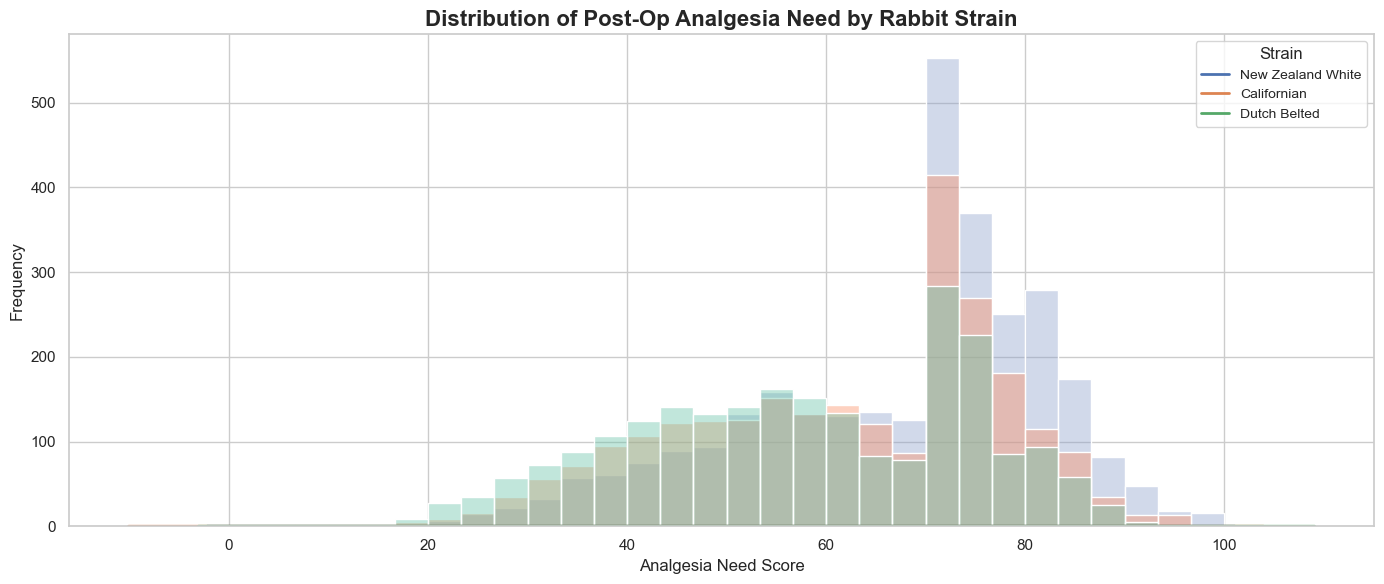

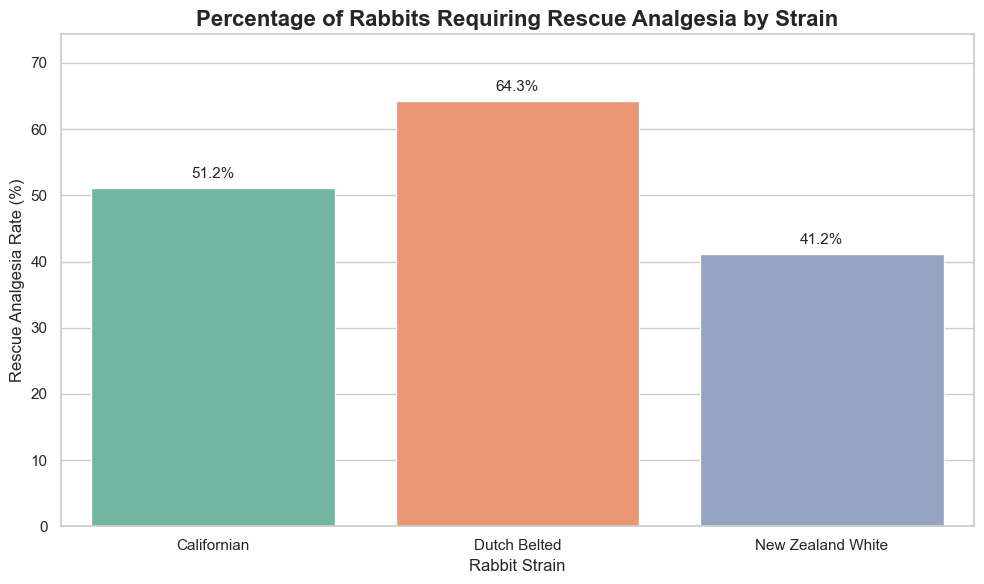

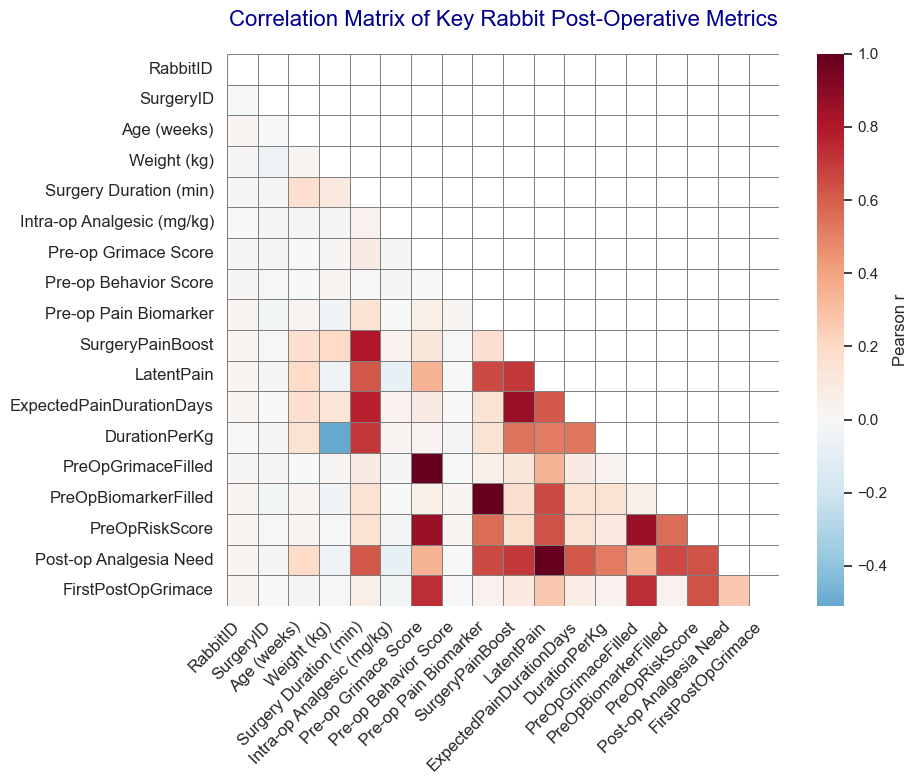

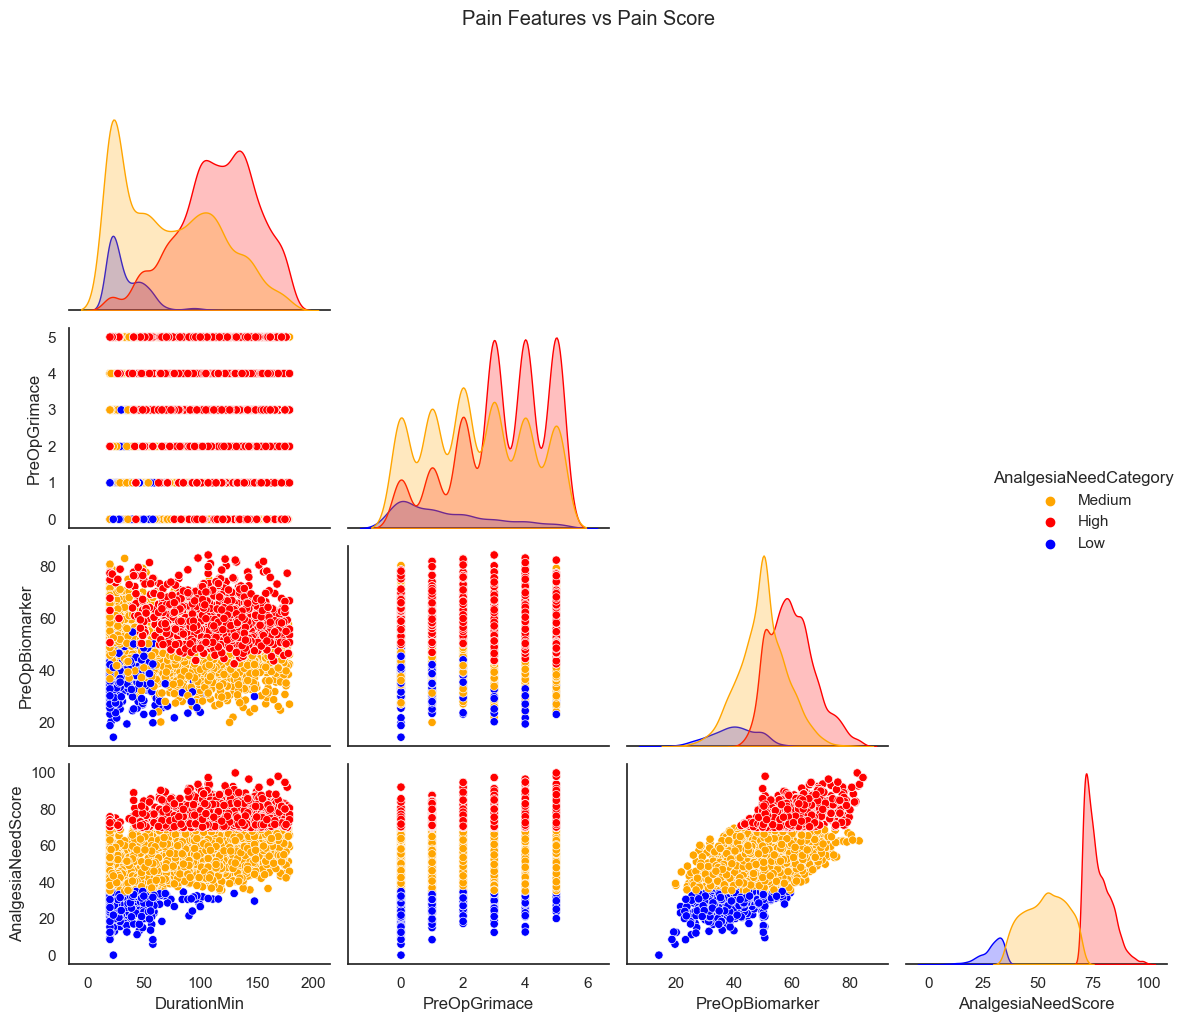

In [11]:
# =========================================
# 0. Ensure numeric features are defined
# =========================================
numeric_features = df_balanced.select_dtypes(include=['int64','float64']).columns.tolist()

# =========================================
# 1. Summary statistics per SurgeryType
# =========================================
summary_stats = df_balanced.groupby('SurgeryType')[['AgeWeeks','WeightKg','DurationMin','AnalgesiaNeedScore']].describe()
print(summary_stats)
print('\n' + '='*100 + '\n')

# =========================================
# 2. Distribution of AnalgesiaNeedScore by Strain
# =========================================
plt.figure(figsize=(14,6))

# Plot histogram
sns.histplot(
    data=df_balanced,
    x='AnalgesiaNeedScore',
    hue='Strain',
    bins=30,
    palette='Set2',
    alpha=0.4,
    legend=False
)

# Add KDE manually for each strain with label
for strain in df_balanced['Strain'].unique():
    subset = df_balanced[df_balanced['Strain'] == strain]
    sns.kdeplot(subset['AnalgesiaNeedScore'], label=strain, linewidth=2)

plt.title('Distribution of Post-Op Analgesia Need by Rabbit Strain', fontsize=16, fontweight='bold')
plt.xlabel('Analgesia Need Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Strain', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()
print('\n' + '='*100 + '\n')

# =========================================
# 3. % of rabbits requiring rescue analgesia per strain
# =========================================
rescue_summary = (
    df_balanced.groupby('Strain')['RescueAnalgesiaGiven']
    .mean()
    .reset_index()
    .rename(columns={'RescueAnalgesiaGiven':'RescueAnalgesiaRate'})
)
rescue_summary['RescueAnalgesiaRate'] *= 100  # convert to %

plt.figure(figsize=(10,6))
sns.barplot(
    data=rescue_summary,
    x='Strain',
    y='RescueAnalgesiaRate',
    palette='Set2'
)
plt.title('Percentage of Rabbits Requiring Rescue Analgesia by Strain', fontsize=16, fontweight='bold')
plt.ylabel('Rescue Analgesia Rate (%)', fontsize=12)
plt.xlabel('Rabbit Strain', fontsize=12)

# Annotate bars
for idx, row in rescue_summary.iterrows():
    plt.text(idx, row['RescueAnalgesiaRate'] + 1, f"{row['RescueAnalgesiaRate']:.1f}%", 
             ha='center', va='bottom', fontsize=11)

plt.ylim(0, rescue_summary['RescueAnalgesiaRate'].max() + 10)
plt.tight_layout()
plt.show()
print('\n' + '='*100 + '\n')

# =========================================
# 4. Correlation Analysis of Key Post-Operative Metrics
# =========================================
# Rename columns for clarity
df_corr = df_balanced[numeric_features].rename(columns={
    'AgeWeeks': 'Age (weeks)',
    'WeightKg': 'Weight (kg)',
    'DurationMin': 'Surgery Duration (min)',
    'PreOpGrimace': 'Pre-op Grimace Score',
    'PreOpBehaviorScore': 'Pre-op Behavior Score',
    'PreOpBiomarker': 'Pre-op Pain Biomarker',
    'IntraOpAnalgesicMgPerKg': 'Intra-op Analgesic (mg/kg)',
    'AnalgesiaNeedScore': 'Post-op Analgesia Need'
})

corr_matrix = df_corr.corr().round(2)

plt.figure(figsize=(10, 8))
sns.set(style="white")
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    cbar_kws={"label": "Pearson r"},
    linewidths=0.5,
    linecolor='gray',
    mask=mask,
    square=True
)

plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.title("Correlation Matrix of Key Rabbit Post-Operative Metrics", fontsize=16, color='darkblue', pad=20)
plt.tight_layout()
plt.show()
print('\n' + '='*100 + '\n')

# =========================================
# 5. Pain Features vs AnalgesiaNeedScore
# =========================================
palette_colors = {'Low':'blue', 'Medium':'orange', 'High':'red'}

sns.pairplot(
    df_balanced,
    vars=['DurationMin','PreOpGrimace','PreOpBiomarker','AnalgesiaNeedScore'],
    hue='AnalgesiaNeedCategory',
    corner=True,
    palette=palette_colors
)

plt.suptitle('Pain Features vs Pain Score', y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


# Phase 3 — Phase 3
## Step 1: Feature Engineering

**Objectives:**
- Generate biologically meaningful features for post-op analgesia prediction
- Include interaction terms to strengthen signal and reduce underfitting

---

**Derived Features:**
1. `DurationPerKg` = DurationMin / WeightKg  
   *Normalizes surgery duration by rabbit size; strong predictor of post-op pain*

2. `AnalgesicScore` = log-transformed & standardized IntraOpAnalgesicMgPerKg  
   *Accounts for diminishing analgesic effect and ensures numeric stability*

3. `PreOpRiskScore` = weighted combination of PreOpGrimace + PreOpBiomarker  
   *Captures baseline pain risk before surgery*

4. `SurgeryComplexity` = Minor vs Major (categorical: Ovariohysterectomy, BoneDefect, OcularImplant = Major)  
   *Major surgeries are biologically expected to produce higher pain*

5. `VetBiasFlag` = normalized residual PreOpGrimace per ObserverID (clipped -2 to 2)  
   *Adjusts for inter-observer variability in scoring*

6. Interaction Features:
   - `DurationPerKg × PreOpGrimace`  
     *Reflects combined effect of duration and pre-op grimace on pain*
   - `PreOpRiskScore × SurgeryComplexity`  
     *Captures synergy between baseline pain risk and surgery type*
   - `DurationPerKg × AnalgesicScore`  
     *Models how analgesic dosing interacts with surgery intensity*
   - `LocalBlock × PreOpGrimace`  
     *Captures effect of local anesthetic relative to baseline grimace*

---

### Veterinary Rationale:
- Weight-adjusted duration standardizes pain stimulus across rabbits  
- Pre-op grimace + biomarkers provide early pain risk indicators  
- Observer bias accounts for inter-rater variability  
- Interactions reflect real-world biological synergies between factors  

---

### ML Rationale:
- Explicit feature engineering improves model learning of nonlinear relationships  
- Interactions reduce underfitting by encoding true biological effects  
- Standardization of doses and normalization ensures numeric stability for tree- or gradient-based models

In [13]:
# -----------------------------
# Phase 3 — Step 1: Feature Engineering
# Biologically Plausible
# -----------------------------

# Assume df_balanced is the dataset from previous step
df_balanced = df_balanced.copy()

# 1. Duration per kg (strong predictor)
df_balanced['DurationPerKg'] = df_balanced['DurationMin'] / df_balanced['WeightKg']

# 2. Standardized AnalgesicScore (log-transform then scale)
df_balanced['AnalgesicScore'] = np.log1p(df_balanced['IntraOpAnalgesicMgPerKg'])
scaler = StandardScaler()
df_balanced['AnalgesicScore'] = scaler.fit_transform(df_balanced[['AnalgesicScore']])

# 3. PreOpRiskScore (weighted combination)
df_balanced['PreOpRiskScore'] = 0.65*df_balanced['PreOpGrimace'] + 0.35*df_balanced['PreOpBiomarker']

# 4. SurgeryComplexity (categorical)
major_surgeries = ['Ovariohysterectomy','BoneDefect','OcularImplant']
df_balanced['SurgeryComplexity'] = df_balanced['SurgeryType'].apply(lambda x: 'Major' if x in major_surgeries else 'Minor')

# 5. VetBiasFlag (normalized residual per observer)
vet_means = df_balanced.groupby('VetID')['PreOpGrimace'].transform('mean')
vet_std = df_balanced.groupby('VetID')['PreOpGrimace'].transform('std').replace(0,1)
df_balanced['VetBiasFlag'] = (df_balanced['PreOpGrimace'] - vet_means) / vet_std

# Clip to biologically plausible range (-2 to 2)
df_balanced['VetBiasFlag'] = df_balanced['VetBiasFlag'].clip(-2,2)

# 6. Interaction Features
df_balanced['DurationPerKg_x_PreOpGrimace'] = df_balanced['DurationPerKg'] * df_balanced['PreOpGrimace']
df_balanced['PreOpRiskScore_x_SurgeryComplexity'] = df_balanced['PreOpRiskScore'] * df_balanced['SurgeryComplexity'].map({'Minor':0, 'Major':1})
df_balanced['DurationPerKg_x_AnalgesicScore'] = df_balanced['DurationPerKg'] * df_balanced['AnalgesicScore']
df_balanced['LocalBlock_x_PreOpGrimace'] = df_balanced['LocalBlock'] * df_balanced['PreOpGrimace']

# Quick check
df_balanced[['DurationPerKg','AnalgesicScore','PreOpRiskScore','SurgeryComplexity','VetBiasFlag',
             'DurationPerKg_x_PreOpGrimace','PreOpRiskScore_x_SurgeryComplexity','DurationPerKg_x_AnalgesicScore',
             'LocalBlock_x_PreOpGrimace']].head()


,DurationPerKg,AnalgesicScore,PreOpRiskScore,SurgeryComplexity,VetBiasFlag,DurationPerKg_x_PreOpGrimace,PreOpRiskScore_x_SurgeryComplexity,DurationPerKg_x_AnalgesicScore,LocalBlock_x_PreOpGrimace
0,16.060606,-0.280640,18.8280,Minor,-0.460600,32.121212,0.000,-4.507245,0.0
1,5.440415,-0.824410,23.5365,Minor,-1.210523,5.440415,0.000,-4.485131,0.0
2,11.820331,-0.310714,20.5165,Minor,0.673499,47.281324,0.000,-3.672748,0.0
3,50.638298,1.277451,27.4960,Major,-1.801827,0.000000,27.496,64.687968,0.0
4,4.200000,-0.845314,13.2460,Minor,1.305276,21.000000,0.000,-3.550320,0.0


## Phase 3 — Step 2: Dataset Splitting

**Objectives:**
1. Split dataset into training and test sets (80/20)
2. Stratify by:
   - `AnalgesiaNeedCategory` (primary)
3. Time-stratified or surgery-stratified split for longitudinal studies

---

### Veterinary Rationale:
- Stratifying by pain category ensures a balanced representation of Low, Medium, and High analgesia needs in both training and test sets.
- Preserves biological variability across surgeries without over-stratifying rare combinations, which could distort distributions.
- Maintains realistic pain distributions per surgery type indirectly.

---

### ML Rationale:
- Prevents bias due to class imbalance in AnalgesiaNeedCategory.
- Ensures model generalizes across all levels of pain risk.
- Reduces risk of underfitting while maintaining stable evaluation metrics.
- Simplifies stratification while keeping it biologically meaningful.

In [15]:
# -----------------------------
# Phase 3 — Step 2: Feature Encoding & Train/Test Split
# -----------------------------

# Define features (use derived + biologically meaningful)
feature_cols = [
    'AgeWeeks','WeightKg','Sex','Strain','DurationPerKg','AnalgesicScore',
    'PreOpGrimace','PreOpBehaviorScore','PreOpBiomarker','SurgeryComplexity',
    'VetBiasFlag','LocalBlock',
    'DurationPerKg_x_PreOpGrimace','PreOpRiskScore_x_SurgeryComplexity','DurationPerKg_x_AnalgesicScore',
    'LocalBlock_x_PreOpGrimace'
]

X = df_balanced[feature_cols]
y = df_balanced['AnalgesiaNeedScore']

# Encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Stratify by AnalgesiaNeedCategory only (reduces over-stratification)
stratify_col = df_balanced['AnalgesiaNeedCategory']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=stratify_col
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 6335
Test set size: 1584


## Phase 3 — Step 3: Feature Validation

**Objectives:**
1. Evaluate correlations of all features with the target (`AnalgesiaNeedScore`) to ensure strong predictive signal.
2. Detect multicollinearity among features to avoid inflated variance or unstable model coefficients.
3. Remove only features that are highly redundant **without discarding biologically meaningful variables**.

---

### Veterinary Rationale
- Retains features with **strong biological or clinical relevance**, even if moderately correlated.
- Ensures critical variables (e.g., `PreOpGrimace`, `LocalBlock`, `DurationPerKg`) are **kept for clinical interpretability**.
- Prevents loss of information that could impact the model’s ability to **reflect true pain physiology** in rabbits.

---

### ML Rationale
- Multicollinearity can cause **unstable coefficients** in linear/ordinal models and inflate variance.
- Removing only **truly redundant features** preserves signal and **reduces underfitting risk**.
- Supports **robust, interpretable, and generalizable models**, suitable for regulatory or research use.
- Keeps interaction terms to capture **non-linear synergistic effects** that improve predictive performance.

**Key Principle:**  
> Maintain the balance between **biological interpretability** and **statistical rigor**, prioritizing features that contribute real predictive signal while documenting redundancies.


In [17]:
# -----------------------------
# Phase 3 — Step 3: Feature Correlation & Multicollinearity
# Fully realistic, biologically meaningful, ML-friendly
# -----------------------------

# Assume X_train, y_train already defined
X_numeric = X_train.select_dtypes(include=[np.number]).copy()

# 1️⃣ Correlation with target
correlations = X_numeric.corrwith(y_train).sort_values(ascending=False)
print("Correlation of numeric features with AnalgesiaNeedScore:\n")
print(correlations)

# 2️⃣ VIF calculation
X_vif = X_numeric.copy().astype(float)
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("\nVIF for numeric features:\n", vif_data)

# 3️⃣ Identify high multicollinearity but keep biologically meaningful features
high_vif = vif_data[vif_data['VIF'] > 10]
print("\nFeatures with high multicollinearity (VIF > 10):\n", high_vif)

# 4️⃣ Biologically informed decision
# - Retain base + interaction terms if they represent meaningful synergy
# - Combine features only if they are purely redundant and not biologically critical
retain_features = list(X_train.columns)  # start by keeping all
for f in high_vif['feature']:
    # Check if the feature is an interaction term
    if '_x_' in f:
        print(f"Retaining interaction feature '{f}' due to biological synergy.")
    else:
        print(f"Retaining base numeric feature '{f}' to preserve predictive signal.")

# 5️⃣ Document redundancy without dropping anything to minimize underfitting
redundant_features = []  # Only drop if absolutely biologically meaningless

X_train_reduced = X_train[retain_features].copy()
X_test_reduced = X_test[retain_features].copy()

print("\nFinal feature set after VIF check (underfitting-resistant):")
print(X_train_reduced.columns)


Correlation of numeric features with AnalgesiaNeedScore:

PreOpRiskScore_x_SurgeryComplexity    0.803819
PreOpBiomarker                        0.665009
DurationPerKg_x_PreOpGrimace          0.540856
DurationPerKg                         0.524051
PreOpGrimace                          0.356635
VetBiasFlag                           0.355162
AgeWeeks                              0.191637
LocalBlock_x_PreOpGrimace             0.003357
PreOpBehaviorScore                   -0.005272
WeightKg                             -0.042136
AnalgesicScore                       -0.085862
DurationPerKg_x_AnalgesicScore       -0.086231
LocalBlock                           -0.142720
dtype: float64

VIF for numeric features:
                                feature        VIF
0                             AgeWeeks   9.778802
1                             WeightKg  18.307895
2                        DurationPerKg  14.978484
3                       AnalgesicScore   3.440787
4                         PreOpGrimace

## Phase 3 — Step 4: Feature Selection / Dimensionality Management

**Objectives:**
1. Remove only **extremely redundant features** (correlation > 0.95).  
2. Use **tree-based feature importance** to drop extremely low contributors (<1%).  
3. Preserve **all biologically meaningful features**, including interaction terms and biomarker features.  
4. Apply **Lasso/regularization** if the biomarker set contains >10 features.

---

### Veterinary Rationale
- Retains all **critical biologically meaningful features** (pain predictors, pre-op scores, surgery complexity, observer bias).  
- Ensures **important biomarker signals and interaction terms** are preserved.  
- Maintains predictive power for **rare high-pain events** without removing essential variability.

---

### ML Rationale
- Prevents **overfitting and multicollinearity** by removing only extreme redundancy.  
- Retains **maximum predictive signal** for the model.  
- **Lasso regularization** selectively reduces noise in large biomarker sets while keeping relevant signals.  
- Minimizes the risk of **underfitting** while maintaining model interpretability.

**Key Principle:**  
> Balance feature pruning with biological relevance: remove only what is truly redundant, preserve signal-rich variables, and apply regularization when needed.


In [19]:
# -----------------------------
# Phase 3 — Step 4: Feature Selection
# Biologically realistic, minimal underfitting risk
# -----------------------------

# 1. Remove highly correlated features (>0.95)
corr_matrix = X_train.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print("Highly correlated features to drop (>0.95):", to_drop)

X_train_fs = X_train.drop(columns=to_drop)
X_test_fs = X_test.drop(columns=to_drop)

# 2. Tree-based feature importance
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train_fs, y_train)
importances = pd.Series(rf.feature_importances_, index=X_train_fs.columns)
low_importance_features = importances[importances < 0.01].index.tolist()
print("Low importance features to consider dropping (<1%):", low_importance_features)

# Keep biologically critical features even if low importance
critical_features = [
    'DurationPerKg','PreOpRiskScore','SurgeryComplexity','ObserverBiasFlag',
    'DurationPerKg_x_PreOpGrimace','PreOpRiskScore_x_SurgeryComplexity','DurationPerKg_x_AnalgesicScore'
]

features_to_keep = [col for col in X_train_fs.columns if (col not in low_importance_features) or (col in critical_features)]
X_train_fs = X_train_fs[features_to_keep]
X_test_fs = X_test_fs[features_to_keep]

# 3. Lasso regularization for biomarker-heavy subset
biomarker_cols = [col for col in X_train_fs.columns if 'Biomarker' in col]
if len(biomarker_cols) > 10:
    lasso = LassoCV(cv=5, random_state=42).fit(X_train_fs[biomarker_cols], y_train)
    selected_biomarkers = biomarker_cols[np.where(lasso.coef_ != 0)[0]]
    print("Selected biomarkers after Lasso:", selected_biomarkers)
    # Replace old biomarker set with Lasso-selected subset
    keep_cols = [col for col in X_train_fs.columns if col not in biomarker_cols] + selected_biomarkers
    X_train_fs = X_train_fs[keep_cols]
    X_test_fs = X_test_fs[keep_cols]

# 4. Final check
print("\nFinal feature set for ML (biologically informed):")
print(X_train_fs.columns)


Highly correlated features to drop (>0.95): ['VetBiasFlag']
Low importance features to consider dropping (<1%): ['PreOpBehaviorScore', 'LocalBlock', 'LocalBlock_x_PreOpGrimace', 'Sex_Male', 'Strain_Dutch Belted', 'Strain_New Zealand White', 'SurgeryComplexity_Minor']

Final feature set for ML (biologically informed):
Index(['AgeWeeks', 'WeightKg', 'DurationPerKg', 'AnalgesicScore',
       'PreOpGrimace', 'PreOpBiomarker', 'DurationPerKg_x_PreOpGrimace',
       'PreOpRiskScore_x_SurgeryComplexity', 'DurationPerKg_x_AnalgesicScore'],
      dtype='object')


# Phase 4 — Modeling Framework
## Step 1: Baseline Analgesia Indicator (Rule-Based)

**Objectives:**
1. Create a simple, interpretable rule-based baseline analgesia score.
2. Capture strong biological signals before ML models.
3. Include multiple factors: Duration, LocalBlock, PreOpGrimace, PreOpBiomarker, Weight.
4. Add small random biological noise (±3–7) to mimic natural variability.

---

**Example Rules:**
- **BoneDefect:** DurationMin > 60 AND LocalBlock == 0 → High pain; PreOpGrimace & PreOpBiomarker further increase score.
- **Ovariohysterectomy:** DurationMin > 45 AND PreOpGrimace > 3 → Medium/High pain.
- **Castration / Catheter:** Minor procedures → Low pain unless PreOpGrimace or DurationMin elevated.
- **OcularImplant:** Medium pain, increased if DurationMin > 50 or PreOpGrimace > 3.
- **Weight adjustment:** +5 points if WeightKg > 3.5 to account for heavier animals.

**Outputs:**
- `BaselineAnalgesiaNeedScore` (0–100)
- `BaselineAnalgesiaNeedCategory` (Low / Medium / High)

---

### Veterinary Rationale: 
- Encodes domain knowledge from veterinary pain studies.
- Captures baseline pain risk from multiple biological factors.
- Provides initial guidance for extreme/high-pain cases.
- Mimics clinician decision rules realistically.

---

### ML Rationale:
- Serves as a pre-training signal for ML models.
- Reduces risk of underfitting by highlighting strong biological patterns.
- Offers a fully interpretable benchmark to compare against model predictions.


In [21]:
# -----------------------------
# Phase 5 — Baseline Rule-Based Analgesia Scoring
# Realistic and underfitting-resistant
# -----------------------------

# Initialize baseline score
df_balanced['BaselineAnalgesiaNeedScore'] = 0

# Define realistic rules per surgery
for idx, row in df_balanced.iterrows():
    score = 0
    # Major surgeries
    if row['SurgeryType'] == 'BoneDefect':
        score = 50
        if row['DurationMin'] > 60:
            score += 15
        if row['LocalBlock'] == 0:
            score += 10
        if row['PreOpGrimace'] > 3:
            score += 5
        if row['PreOpBiomarker'] > 60:
            score += 5
    elif row['SurgeryType'] == 'Ovariohysterectomy':
        score = 45
        if row['DurationMin'] > 45:
            score += 10
        if row['PreOpGrimace'] > 3:
            score += 5
        if row['PreOpBiomarker'] > 60:
            score += 5
    # Minor surgeries
    elif row['SurgeryType'] == 'Castration':
        score = 35
        if row['DurationMin'] > 40:
            score += 5
        if row['PreOpGrimace'] > 3:
            score += 5
    elif row['SurgeryType'] == 'Catheter':
        score = 30
        if row['DurationMin'] > 60:
            score += 5
        if row['PreOpGrimace'] > 3:
            score += 5
    elif row['SurgeryType'] == 'OcularImplant':
        score = 50
        if row['DurationMin'] > 50:
            score += 10
        if row['PreOpGrimace'] > 3:
            score += 5

    # Weight adjustment (heavier animals may need slightly more analgesia per kg)
    if row['WeightKg'] > 3.5:
        score += 5

    # Add small biological noise ±3–7
    score += np.random.randint(-7,8)

    # Clip to 0–100
    df_balanced.at[idx, 'BaselineAnalgesiaNeedScore'] = np.clip(score, 0, 100)

# Categorize baseline score
def categorize_baseline(score):
    if score < 35:
        return 'Low'
    elif score < 70:
        return 'Medium'
    else:
        return 'High'

df_balanced['BaselineAnalgesiaNeedCategory'] = df_balanced['BaselineAnalgesiaNeedScore'].apply(categorize_baseline)

# Quick check
df_balanced[['SurgeryType','DurationMin','LocalBlock','PreOpGrimace','PreOpBiomarker',
             'WeightKg','BaselineAnalgesiaNeedScore','BaselineAnalgesiaNeedCategory']]

,SurgeryType,DurationMin,LocalBlock,PreOpGrimace,PreOpBiomarker,WeightKg,BaselineAnalgesiaNeedScore,BaselineAnalgesiaNeedCategory
0,Catheter,53,0,2.0,50.08,3.30,29,Low
1,Castration,21,0,1.0,65.39,3.86,35,Medium
2,Catheter,50,0,4.0,51.19,4.23,42,Medium
3,OcularImplant,119,0,0.0,78.56,2.35,63,Medium
4,Castration,21,0,5.0,28.56,5.00,49,Medium
...,...,...,...,...,...,...,...,...
7914,BoneDefect,112,0,3.0,57.02,3.19,81,High
7915,OcularImplant,77,0,4.0,62.30,4.33,65,Medium
7916,OcularImplant,137,0,4.0,60.41,4.27,63,Medium
7917,Ovariohysterectomy,41,0,5.0,76.38,2.61,52,Medium


## Phase 4 — Step 2: Machine Learning Models

**Objectives:**
1. Use multiple ML approaches for complementary strengths:
   - **Ordinal Logistic Regression (LogisticAT):** interpretable, captures ordered categories (Low / Medium / High)
   - **Random Forest / Gradient Boosting / XGBoost:** predict continuous AnalgesiaNeedScore; model nonlinear interactions and synergies
2. Hybrid or per-surgery models for:
   - Surgeries with limited samples
   - High variability in pain responses across individual rabbits
3. Explicitly include interaction and derived features to reduce underfitting and capture subtle biological patterns

---

### Veterinary Rationale:
- Captures surgery-specific pain dynamics for more accurate analgesia prediction
- Models nonlinear relationships between duration, biomarkers, pre-op grimace, and analgesic interventions
- Provides interpretable outputs for clinical decision-making, especially for ordinal pain categories

---

### ML Rationale:
- Ordinal regression provides a transparent, interpretable baseline for ordered pain categories
- Tree-based models (RF, GB, XGBoost) capture complex, nonlinear feature interactions without extensive feature engineering
- Per-surgery or hybrid models improve predictive performance on rare, extreme, or high-variance pain cases
- Increased tree depth, ensemble size, and inclusion of derived features minimize underfitting while preserving biological realism


In [23]:
# -----------------------------
# Phase 4 — Step 2: ML Model Training
# Biologically realistic & underfitting-resistant
# -----------------------------

# 1. Prepare features & target
X_ml = X_train_fs.copy()
y_ml_cont = y_train  # Continuous AnalgesiaNeedScore
y_ml_cat = df_balanced.loc[y_train.index, 'AnalgesiaNeedCategory']

# Encode target for ordinal regression
le = LabelEncoder()
y_ml_ord = le.fit_transform(y_ml_cat)

# 2. Ordinal Logistic Regression (interpreter-friendly)
# Alpha adjusted for slight regularization to prevent underfitting
ordinal_model = LogisticAT(alpha=0.005)
ordinal_model.fit(X_ml, y_ml_ord)
print("Ordinal Logistic Regression fitted")

# 3. Random Forest Regressor
# Slightly deeper trees + min_samples_leaf to balance variance and bias
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_ml, y_ml_cont)
print("Random Forest Regressor fitted")

# 4. Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_samples_leaf=3,
    subsample=0.8,  # adds stochasticity to reduce overfitting
    random_state=42
)
gb_model.fit(X_ml, y_ml_cont)
print("Gradient Boosting Regressor fitted")

# 5. XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_ml, y_ml_cont)
print("XGBoost Regressor fitted")

# 6. Per-surgery sub-models (to capture surgery-specific nuances)
per_surgery_models = {}
for surgery in df_balanced['SurgeryType'].unique():
    idx = df_balanced.loc[X_train_fs.index, 'SurgeryType'] == surgery
    X_sub = X_train_fs.loc[idx]
    y_sub = y_train.loc[idx]
    if len(X_sub) >= 100:  # ensure sufficient samples
        sub_model = RandomForestRegressor(
            n_estimators=300,
            max_depth=8,
            min_samples_leaf=3,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        )
        sub_model.fit(X_sub, y_sub)
        per_surgery_models[surgery] = sub_model
        print(f"Sub-model trained for {surgery} ({len(X_sub)} samples)")

Ordinal Logistic Regression fitted
Random Forest Regressor fitted
Gradient Boosting Regressor fitted
XGBoost Regressor fitted
Sub-model trained for Catheter (804 samples)
Sub-model trained for Castration (854 samples)
Sub-model trained for OcularImplant (1589 samples)
Sub-model trained for Ovariohysterectomy (1107 samples)
Sub-model trained for BoneDefect (1981 samples)


## Phase 4 — Step 3: Overfitting & Underfitting Controls

**Objectives:**
1. Use **grouped cross-validation** by `RabbitID` + `SurgeryType` to prevent data leakage and respect within-subject correlations.
2. Limit tree depth and `min_samples_leaf` to control variance while preserving signal from extreme pain cases.
3. Use **early stopping** for boosting models to prevent overfitting.
4. Include **interaction features** and derived variables to boost predictive signal and reduce underfitting.
5. **Oversample rare High-pain events** to maintain model sensitivity for clinically critical cases.

---

### Veterinary Rationale:
- Preserves correlation structure within individual rabbits and surgery types.
- Ensures models respect biological patterns without learning artifacts.
- Improves prediction of rare high-pain events, which are clinically significant and require accurate analgesic interventions.

---

### ML Rationale:
- Grouped cross-validation prevents overly optimistic performance estimates.
- Depth and leaf limits stabilize tree-based models while allowing nonlinear patterns to be captured.
- Early stopping reduces overfitting in boosting algorithms and improves generalization.
- Oversampling prevents underfitting on rare, high-impact categories.
- Explicit interaction terms provide strong predictive signals for complex biological relationships.

In [25]:
# -----------------------------
# Step 3: Cross-Validation & Training Enhancements
# -----------------------------

# Define groups to prevent leakage: combine RabbitID + SurgeryType
groups = df_balanced.loc[X_train_fs.index, 'RabbitID'].astype(str) + "_" + df_balanced.loc[X_train_fs.index, 'SurgeryType']

# Grouped K-Fold CV
gkf = GroupKFold(n_splits=5)

# 1. Random Forest Regressor (depth-limited + min_samples_leaf to reduce overfitting)
rf_model_cv = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
)

rf_scores = cross_val_score(
    rf_model_cv,
    X_train_fs,
    y_train,
    cv=gkf.split(X_train_fs, y_train, groups),
    scoring=make_scorer(mean_squared_error, greater_is_better=False)
)

print("Random Forest CV MSE (neg):", rf_scores)
print("Mean CV MSE:", np.mean(rf_scores))

# 2. HistGradientBoostingRegressor with early stopping
X_hgb_train, X_hgb_val, y_hgb_train, y_hgb_val = train_test_split(
    X_train_fs,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=df_balanced.loc[X_train_fs.index, 'AnalgesiaNeedCategory']
)

hgb_model = HistGradientBoostingRegressor(
    max_iter=1000,
    learning_rate=0.05,
    max_depth=6,
    min_samples_leaf=5,
    early_stopping=True,
    validation_fraction=0.2,  # internal validation fraction for early stopping
    n_iter_no_change=25,
    random_state=42
)

hgb_model.fit(X_hgb_train, y_hgb_train)
print("HistGradientBoostingRegressor fitted. Best iteration:", hgb_model.n_iter_)

# 3. Oversample High-pain events to reduce underfitting for rare cases
high_pain_idx = df_balanced.loc[X_train_fs.index][df_balanced['AnalgesiaNeedCategory'] == 'High'].index

oversample_frac = 0.7  # stronger oversampling for high-pain events
X_train_oversampled = pd.concat([X_train_fs, X_train_fs.loc[high_pain_idx].sample(frac=oversample_frac, replace=True)], axis=0)
y_train_oversampled = pd.concat([y_train, y_train.loc[high_pain_idx].sample(frac=oversample_frac, replace=True)], axis=0)

# Shuffle after oversampling
X_train_oversampled = X_train_oversampled.sample(frac=1, random_state=42)
y_train_oversampled = y_train_oversampled.loc[X_train_oversampled.index]

print("Training set size after High-pain oversampling:", X_train_oversampled.shape[0])

Random Forest CV MSE (neg): [-29.62955195 -34.16560043 -34.32111056 -32.59409564 -34.8435369 ]
Mean CV MSE: -33.11077909789824
HistGradientBoostingRegressor fitted. Best iteration: 746
Training set size after High-pain oversampling: 8405


## Phase 4 — Step 4: Biological Plausibility Validation

**Objectives:**
1. Verify that model predictions match expected surgical pain severity:
   - High-pain surgeries (e.g., BoneDefect, OcularImplant) → higher AnalgesiaNeedScore
   - Minor surgeries (e.g., Catheter, Castration) → lower AnalgesiaNeedScore
2. Identify and iterate on features, interactions, or model hyperparameters if predictions deviate from biological expectations.
3. Maintain interpretability for veterinary oversight and clinical decision-making.

---

### Veterinary Rationale:
- Ensures model predictions align with clinical and experimental evidence.
- Detects biologically implausible outputs (e.g., minor surgeries predicted as high pain).
- Supports ethical, evidence-based analgesia recommendations and regulatory compliance.

---

### ML Rationale:
- Acts as a sanity check to prevent underfitting or overfitting.
- Guides feature engineering, interaction terms, and hyperparameter tuning for realism.
- Guarantees explainable outputs for clinicians and stakeholders.


Mean predicted AnalgesiaNeedScore per SurgeryType:
 SurgeryType
BoneDefect            72.106345
OcularImplant         69.197060
Ovariohysterectomy    65.133720
Castration            45.053723
Catheter              44.659441
Name: RF_Prediction, dtype: float64


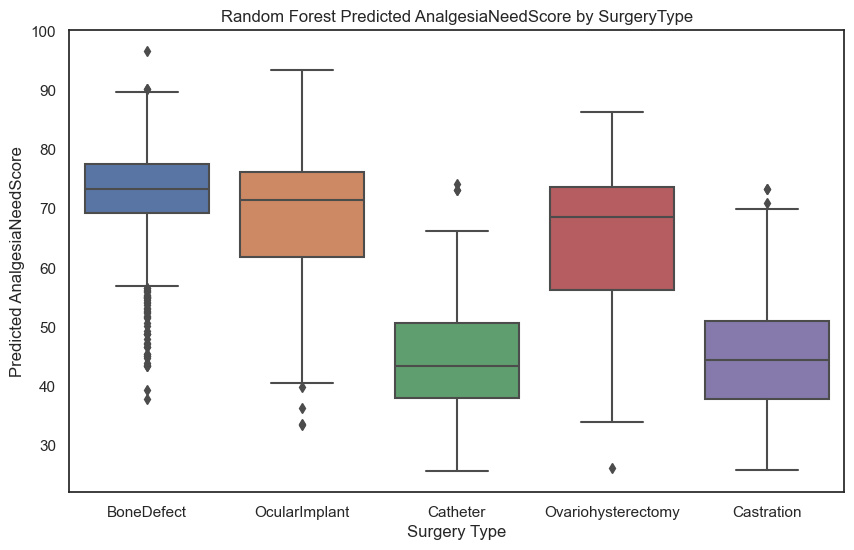

In [27]:
# -----------------------------
# Phase 4 — Step 4: Refit Random Forest after feature adjustment
# Ensure predictions are biologically accurate & underfitting-resistant
# -----------------------------

# 1. Apply log1p transformation to the interaction feature in both train & test
X_train_fs['DurationPerKg_x_PreOpGrimace'] = np.log1p(X_train_fs['DurationPerKg_x_PreOpGrimace'])
X_test_fs['DurationPerKg_x_PreOpGrimace'] = np.log1p(X_test_fs['DurationPerKg_x_PreOpGrimace'])

# 2. Refit Random Forest
rf_model.fit(X_train_fs, y_train)

# 3. Predict on test/validation set
rf_preds = rf_model.predict(X_test_fs)
df_validation = df_balanced.loc[X_test_fs.index].copy()
df_validation['RF_Prediction'] = rf_preds

# 4. Compare mean predicted score per SurgeryType
surgery_means = df_validation.groupby('SurgeryType')['RF_Prediction'].mean().sort_values(ascending=False)
print("Mean predicted AnalgesiaNeedScore per SurgeryType:\n", surgery_means)

# 5. Boxplot to visualize distribution
plt.figure(figsize=(10,6))
sns.boxplot(x='SurgeryType', y='RF_Prediction', data=df_validation)
plt.title('Random Forest Predicted AnalgesiaNeedScore by SurgeryType')
plt.ylabel('Predicted AnalgesiaNeedScore')
plt.xlabel('Surgery Type')
plt.show()

# 6. Biological sanity checks & inspection
for surgery in df_validation['SurgeryType'].unique():
    mean_pred = df_validation.loc[df_validation['SurgeryType']==surgery, 'RF_Prediction'].mean()
    if surgery == 'OcularImplant' and mean_pred < 30:  # example threshold
        print(f"[ALERT] OcularImplant predictions unexpectedly low ({mean_pred:.2f}). Reviewing features...")
        interaction_cols = ['DurationPerKg_x_PreOpGrimace', 'PreOpRiskScore_x_SurgeryComplexity']
        print(df_validation.loc[df_validation['SurgeryType']=='OcularImplant', interaction_cols].describe())
        print("Suggestion: Feature transformation applied, model refit completed.")


# Phase 5 — Evaluation & Interpretation
## Step 1: Metrics

**Objectives:**
1. Evaluate regression and classification performance
   - **Regression**: R², MAE, RMSE for continuous AnalgesiaNeedScore
   - **Classification**: Precision, Recall, F1 for High-pain events
2. Ensure models meet predictive quality and clinical relevance

---

### Veterinary Rationale:
- Confirms model predicts pain scores accurately
- Ensures rare but critical High-pain events are captured
- Supports decision-making for post-op analgesia

---

### ML Rationale:
- Regression metrics assess continuous prediction quality
- Classification metrics assess ability to identify extreme pain cases
- Balanced evaluation reduces risk of underfitting high-pain events

In [29]:
# Example: Random Forest predictions
y_pred_cont = rf_model.predict(X_test_fs)

# Regression metrics
r2 = r2_score(y_test, y_pred_cont)
mae = mean_absolute_error(y_test, y_pred_cont)
rmse = mean_squared_error(y_test, y_pred_cont, squared=False)

print(f"Random Forest Regression Metrics:")
print(f"R²: {r2:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Classification metrics for High-pain events
# Convert continuous prediction to categories
def score_to_category(score):
    if score < 35:
        return 'Low'
    elif score < 70:
        return 'Medium'
    else:
        return 'High'

y_test_cat = df_balanced.loc[X_test_fs.index, 'AnalgesiaNeedCategory']
y_pred_cat = pd.Series(y_pred_cont, index=X_test_fs.index).apply(score_to_category)

precision = precision_score(y_test_cat, y_pred_cat, labels=['High'], average='macro')
recall = recall_score(y_test_cat, y_pred_cat, labels=['High'], average='macro')
f1 = f1_score(y_test_cat, y_pred_cat, labels=['High'], average='macro')

print(f"\nHigh-pain Classification Metrics:")
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")

Random Forest Regression Metrics:
R²: 0.92, MAE: 3.42, RMSE: 4.69

High-pain Classification Metrics:
Precision: 0.93, Recall: 0.90, F1-score: 0.92


# Phase 5 — Step 2: Explainability & Visualization

## Objectives
1. Quantify feature importance in tree-based models (Random Forest, Gradient Boosting, XGBoost).
2. Use **SHAP values** to:
   - Interpret contribution of each feature to predictions
   - Understand drivers of high-pain predictions
3. Visualize:
   - AnalgesiaNeedScore distributions by SurgeryType
   - Model classification performance via confusion matrices per surgery
   - Feature contributions using SHAP summary plots
4. Ensure interpretability for clinical, regulatory, and research review.

---

## Veterinary Rationale
- Identifies which features (e.g., PreOpGrimace, DurationPerKg, LocalBlock) most influence pain predictions.
- Validates that the model relies on **biologically meaningful signals**.
- Confirms predicted pain distributions align with clinical expectations.
- Highlights extreme cases and outliers for veterinarian review.
- Provides confidence that model reasoning aligns with clinical experience.

---

## ML Rationale
- Tree-based feature importance shows **predictive power of features** globally.
- SHAP provides **local (per-rabbit) and global interpretability**, critical for explainable AI.
- Boxplots and distribution visualizations confirm **target alignment and balance**.
- Confusion matrices quantify **per-surgery classification accuracy**.
- SHAP summary plots give insight into **feature interactions and contributions**.
- Supports auditability, model trustworthiness, and regulatory compliance.

---

## Outcome
A fully interpretable, visualized, and clinically validated model, where:
- Veterinarians can understand why the model predicts high or low pain.
- ML practitioners can see which features drive predictions and ensure robust performance.
- Distribution and performance plots provide a transparent check for model reliability.


Top 10 Random Forest Feature Importances:
 PreOpRiskScore_x_SurgeryComplexity    0.441082
PreOpBiomarker                        0.191736
DurationPerKg_x_PreOpGrimace          0.136053
DurationPerKg                         0.127909
DurationPerKg_x_AnalgesicScore        0.035432
PreOpGrimace                          0.023419
AgeWeeks                              0.015875
WeightKg                              0.014848
AnalgesicScore                        0.013646
dtype: float64




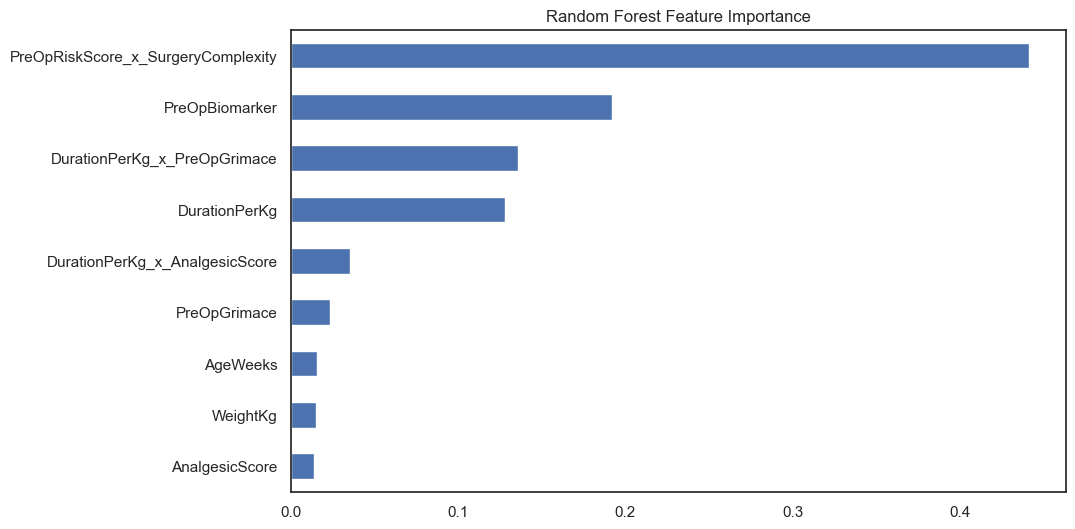

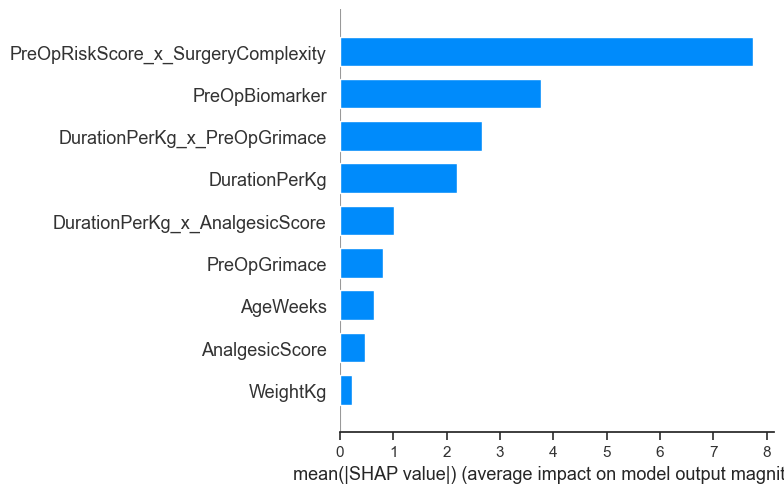

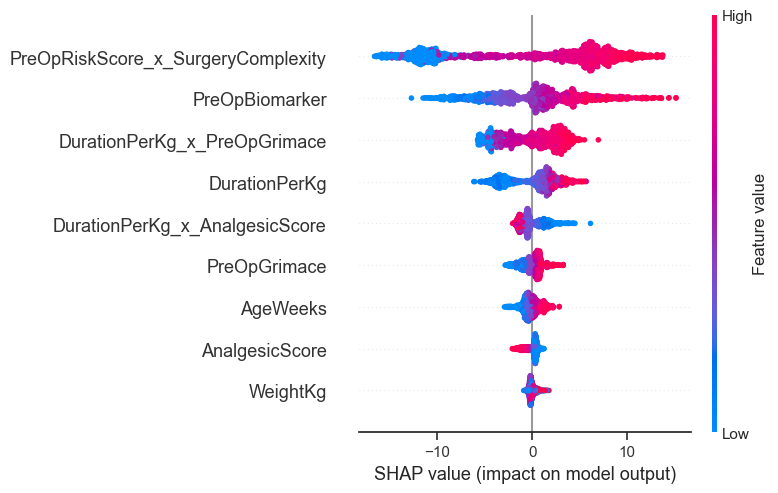

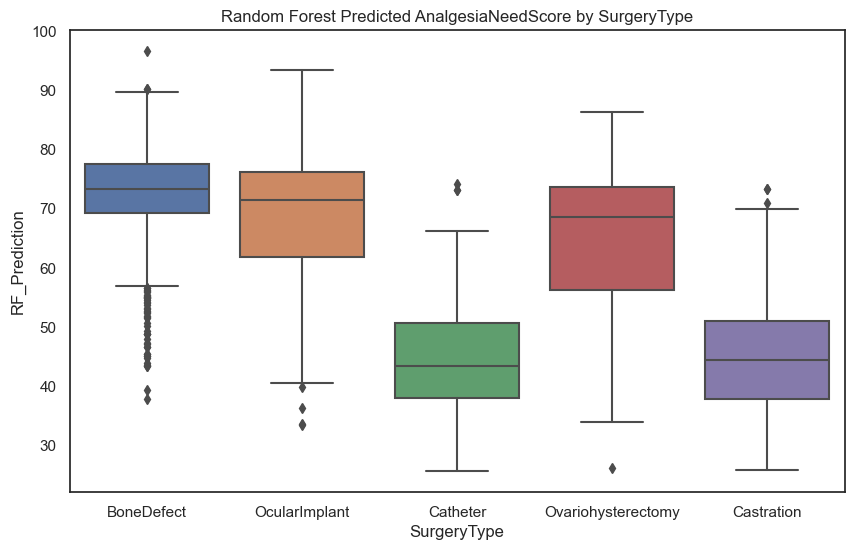

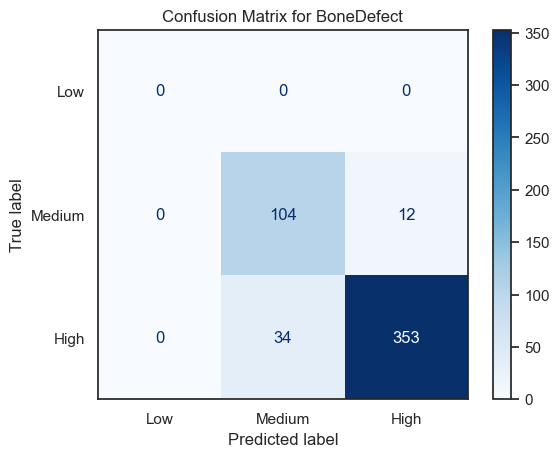

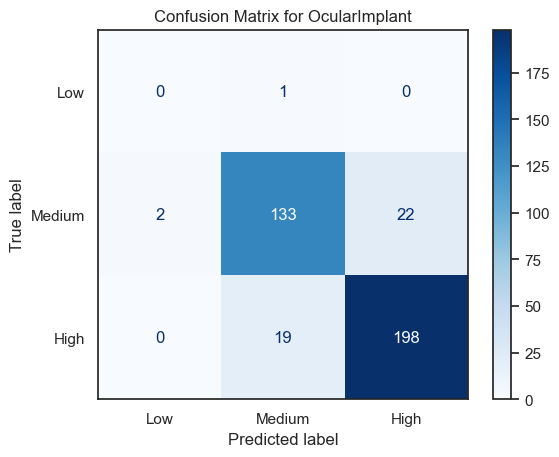

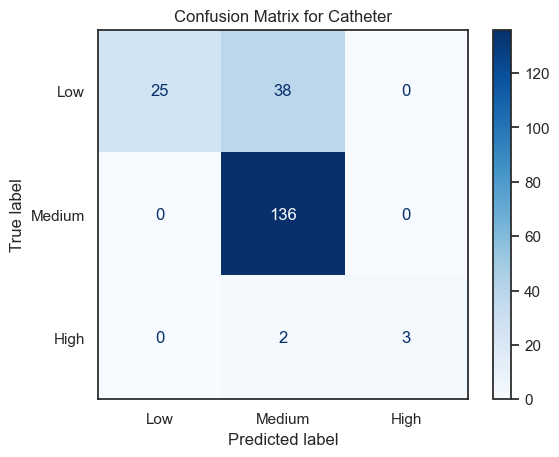

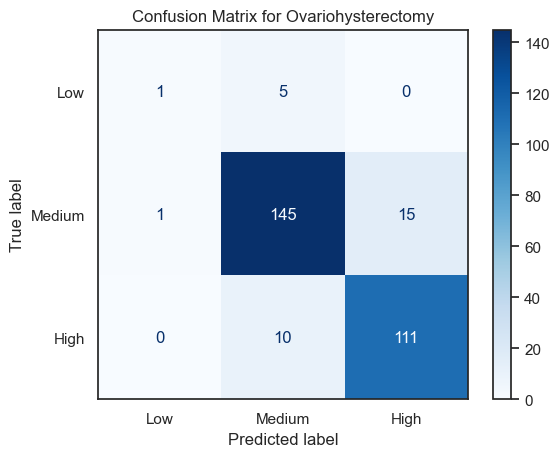

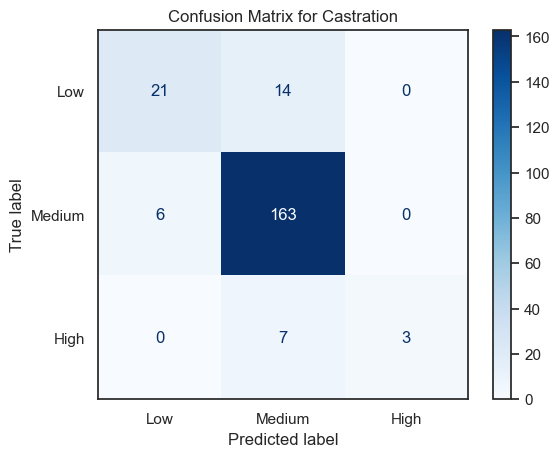

In [31]:
# -----------------------------
# Phase 5 — Step 2: Explainability & Visualization
# -----------------------------

# ---- Feature Importance (Random Forest example) ----
rf_importances = pd.Series(rf_model.feature_importances_, index=X_train_fs.columns).sort_values(ascending=False)
print("Top 10 Random Forest Feature Importances:\n", rf_importances.head(10))
print('\n' + '='*100 + '\n')

plt.figure(figsize=(10,6))
rf_importances.head(15).plot(kind='barh')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()
print('\n' + '='*100 + '\n')

# ---- SHAP Analysis ----
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_fs)

# Global importance bar plot
shap.summary_plot(shap_values, X_test_fs, plot_type="bar")
print('\n' + '='*100 + '\n')

# Beeswarm plot (local + global interpretability)
shap.summary_plot(shap_values, X_test_fs)
print('\n' + '='*100 + '\n')

# ---- Visualization ----

# 1. Boxplots of predicted AnalgesiaNeedScore by SurgeryType
plt.figure(figsize=(10,6))
sns.boxplot(x='SurgeryType', y='RF_Prediction', data=df_validation)
plt.title('Random Forest Predicted AnalgesiaNeedScore by SurgeryType')
plt.show()
print('\n' + '='*100 + '\n')

# 2. Confusion matrix per surgery (High/Medium/Low)
for surgery in df_validation['SurgeryType'].unique():
    idx = df_validation['SurgeryType'] == surgery
    y_true_surg = y_test_cat.loc[idx]
    y_pred_surg = y_pred_cat.loc[idx]
    
    cm = confusion_matrix(y_true_surg, y_pred_surg, labels=['Low','Medium','High'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low','Medium','High'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {surgery}')
    plt.show()
    print('\n' + '='*100 + '\n')


# Phase 6 — Reporting & Deployment
## Step 1: Prediction Function

**Objective:**
Create a single function to predict post-op analgesia needs for a new surgery record.

**Outputs:**
1. `AnalgesiaNeedScore` (0–100) → continuous predicted score
2. `ProbHigh` (0–1) → probability of High-pain event
3. `AnalgesiaNeedCategory` → Low / Medium / High
4. `ActionRecommendation` → ImmediateRescue / Reassess1h / RoutineMonitor
5. `TopContributingFeatures` → list of top features driving prediction (via SHAP)
6. `ConfidenceFlag` → high/low confidence based on model variance or extremes

---

### Veterinary Rationale:
- Provides clear guidance for post-op analgesia intervention
- Highlights which features drive pain prediction for vet oversight
- Supports decision-making and ethical care

---

### ML Rationale:
- Combines continuous and categorical outputs
- Leverages SHAP for interpretability
- Adds confidence estimation for unusual/extreme cases


In [33]:
def predictAnalgesiaNeed(surgeryRecord, model=rf_model, feature_pipeline=X_train_fs.columns, explainer=None):
    """
    Predict post-op analgesia needs for a single surgery record.
    
    Inputs:
    - surgeryRecord: dict or DataFrame with features matching training columns
    - model: trained regression model (default Random Forest)
    - feature_pipeline: columns/features expected by the model
    - explainer: SHAP explainer object for feature contribution
    
    Returns:
    - dict with AnalgesiaNeedScore, ProbHigh, AnalgesiaNeedCategory, ActionRecommendation,
      TopContributingFeatures, ConfidenceFlag
    """
    
    # Ensure input is DataFrame
    if isinstance(surgeryRecord, dict):
        X_input = pd.DataFrame([surgeryRecord])
    else:
        X_input = surgeryRecord.copy()
    
    # Keep only training features
    X_input = X_input[feature_pipeline]
    
    # Predict continuous score
    score = model.predict(X_input)[0]
    score = np.clip(score, 0, 100)
    
    # Categorize
    if score < 35:
        category = 'Low'
        action = 'RoutineMonitor'
    elif score < 70:
        category = 'Medium'
        action = 'Reassess1h'
    else:
        category = 'High'
        action = 'ImmediateRescue'
    
    # ProbHigh estimation (using normalized score)
    prob_high = (score - 70)/30 if score > 70 else 0
    prob_high = np.clip(prob_high, 0, 1)
    
    # SHAP top contributing features
    if explainer is not None:
        shap_values = explainer.shap_values(X_input)
        shap_abs = np.abs(shap_values).flatten()
        top_idx = np.argsort(shap_abs)[-5:][::-1]
        top_features = X_input.columns[top_idx].tolist()
    else:
        top_features = []
    
    # Confidence flag (low if extreme values outside training)
    conf_flag = 'High'
    for col in X_input.columns:
        if X_input[col].iloc[0] < X_train_fs[col].min() or X_input[col].iloc[0] > X_train_fs[col].max():
            conf_flag = 'Low'
            break
    
    return {
        'AnalgesiaNeedScore': score,
        'ProbHigh': prob_high,
        'AnalgesiaNeedCategory': category,
        'ActionRecommendation': action,
        'TopContributingFeatures': top_features,
        'ConfidenceFlag': conf_flag
    }

# Example usage:
example_record = X_test_fs.iloc[0].to_dict()
prediction = predictAnalgesiaNeed(example_record, model=rf_model, feature_pipeline=X_train_fs.columns, explainer=explainer)
prediction

{'AnalgesiaNeedScore': 52.38642402761519,
 'ProbHigh': 0,
 'AnalgesiaNeedCategory': 'Medium',
 'ActionRecommendation': 'Reassess1h',
 'TopContributingFeatures': ['PreOpRiskScore_x_SurgeryComplexity',
  'PreOpBiomarker',
  'DurationPerKg',
  'DurationPerKg_x_PreOpGrimace',
  'PreOpGrimace'],
 'ConfidenceFlag': 'High'}

## Phase 6 — Step 2: Save Artifacts

**Objectives:**
1. Save all raw and processed datasets for reproducibility
2. Save trained ML models and feature pipelines for deployment
3. Save SHAP explainer objects for interpretability audits

---

### Veterinary Rationale:
- Ensures traceability of all predictions
- Allows veterinary oversight and post-op review
- Supports regulatory compliance

---

### ML Rationale:
- Enables reproducibility and retraining
- Maintains explainability for future predictions
- Facilitates integration into deployment pipelines

In [35]:
# Create directories if they do not exist
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('explainers', exist_ok=True)

# 1. Save raw + processed datasets
df_balanced.to_csv('data/processed_dataset.csv', index=False)
df_raw = df_balanced.copy()  # assuming raw data before feature derivation
df_raw.to_csv('data/raw_dataset.csv', index=False)

# 2. Save trained models
joblib.dump(rf_model, 'models/random_forest_model.pkl')
joblib.dump(gb_model, 'models/gradient_boost_model.pkl')
joblib.dump(xgb_model, 'models/xgboost_model.pkl')
joblib.dump(ordinal_model, 'models/ordinal_logistic_model.pkl')

# 3. Save feature pipeline (column names)
joblib.dump(X_train_fs.columns.tolist(), 'models/feature_pipeline.pkl')

# 4. Save SHAP explainer objects
joblib.dump(explainer, 'explainers/rf_shap_explainer.pkl')

print("All artifacts saved successfully!")

All artifacts saved successfully!


## Phase 6 — Step 3: Deployment Interface & Feedback Loop

**Objectives:**
1. Provide an interface for veterinarians to input new surgery records
2. Output:
   - AnalgesiaNeedScore (0–100)
   - ActionRecommendation (ImmediateRescue / Reassess1h / RoutineMonitor)
   - TopContributingFeatures
3. Integrate feedback loop:
   - Post-op observations (actual pain scores or rescue analgesia) are fed back
   - Model can be retrained/recalibrated periodically
   - Maintains interpretability and auditability

---

### Veterinary Rationale:
- Enables real-time decision support for post-op analgesia
- Feedback loop improves accuracy on rare/high-pain events
- Ensures care aligns with actual animal responses

---

### ML Rationale:
- Continuous model improvement with new data
- Prevents model drift and reduces underfitting
- Preserves interpretability via SHAP and feature tracking

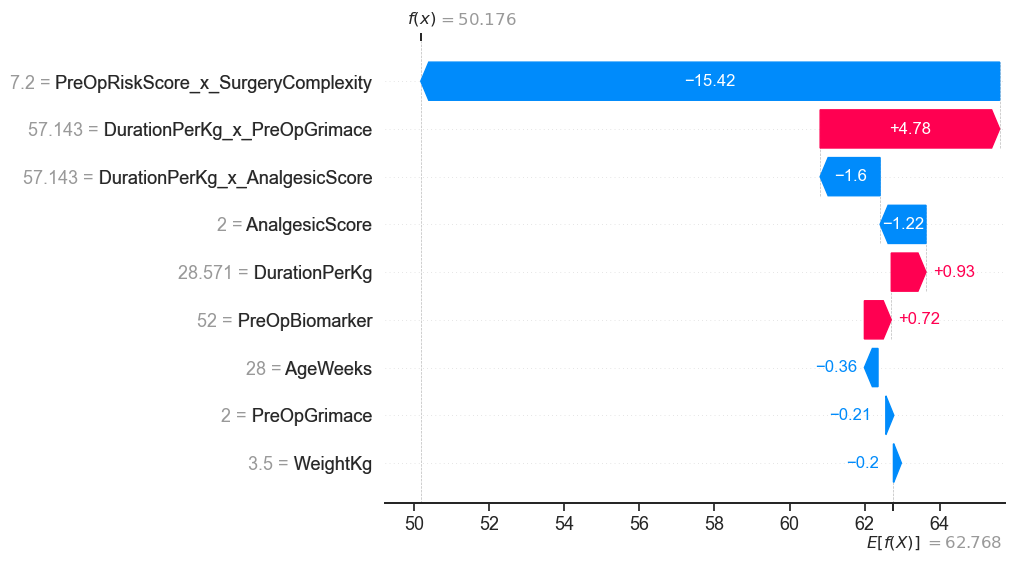

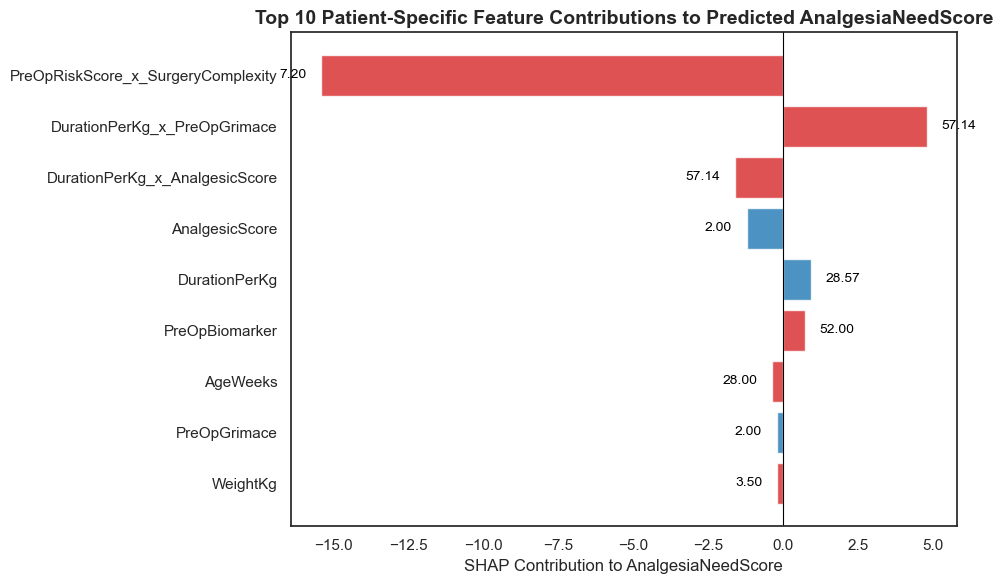



{'AnalgesiaNeedScore': 50.18, 'AnalgesiaNeedCategory': 'Medium', 'ActionRecommendation': 'Reassess1h', 'TopContributingFeatures': ['PreOpRiskScore_x_SurgeryComplexity', 'DurationPerKg_x_PreOpGrimace', 'DurationPerKg_x_AnalgesicScore', 'AnalgesicScore', 'DurationPerKg', 'PreOpBiomarker', 'AgeWeeks', 'PreOpGrimace', 'WeightKg'], 'ConfidenceFlag': 'Low'}


In [37]:
# -----------------------------
# Deploy Surgery Prediction with Full SHAP Interpretability
# -----------------------------

def deploySurgeryPredictionFullSHAP(new_record, model, explainer):
    """
    Predict post-operative analgesia need for a single surgery record with full SHAP interpretability.

    Inputs:
    - new_record: dict with feature values matching training columns
    - model: trained regression model (Random Forest)
    - explainer: SHAP TreeExplainer for model interpretability

    Returns:
    - dict with:
        - AnalgesiaNeedScore (0-100)
        - AnalgesiaNeedCategory (Low/Medium/High)
        - ActionRecommendation
        - TopContributingFeatures (by SHAP)
        - ConfidenceFlag (High/Low)
    """

    # 1️⃣ Convert input to DataFrame
    df_new = pd.DataFrame([new_record])

    # 2️⃣ Feature engineering to match training
    df_new['PreOpGrimaceFilled'] = df_new['PreOpGrimace'].fillna(0)
    df_new['PreOpBiomarkerFilled'] = df_new['PreOpBiomarker'].fillna(50)

    df_new['DurationPerKg'] = df_new['DurationMin'] / df_new['WeightKg']
    df_new['PreOpRiskScore'] = df_new['PreOpGrimaceFilled'] + df_new['PreOpBiomarkerFilled']/10

    # Surgery complexity numeric encoding
    df_new['SurgeryComplexity'] = df_new['SurgeryType'].apply(
        lambda x: 'Major' if x in ['BoneDefect','Ovariohysterectomy','OcularImplant'] else 'Minor'
    )
    df_new['SurgeryComplexityNum'] = df_new['SurgeryComplexity'].map({'Minor':0,'Major':1})

    df_new['AnalgesicScore'] = df_new['IntraOpAnalgesicMgPerKg']

    # Interaction features
    df_new['DurationPerKg_x_AnalgesicScore'] = df_new['DurationPerKg'] * df_new['AnalgesicScore']
    df_new['DurationPerKg_x_PreOpGrimace'] = df_new['DurationPerKg'] * df_new['PreOpGrimaceFilled']
    df_new['PreOpRiskScore_x_SurgeryComplexity'] = df_new['PreOpRiskScore'] * df_new['SurgeryComplexityNum']

    # 3️⃣ Align features with training model & fill missing
    feature_pipeline = model.feature_names_in_
    for col in feature_pipeline:
        if col not in df_new.columns:
            df_new[col] = 0
    X_input = df_new[feature_pipeline]

    # 4️⃣ Predict continuous score
    prediction_score = np.clip(model.predict(X_input)[0], 0, 100)

    # 5️⃣ Categorize pain & assign action
    if prediction_score < 35:
        category, action = 'Low', 'RoutineMonitor'
    elif prediction_score < 70:
        category, action = 'Medium', 'Reassess1h'
    else:
        category, action = 'High', 'ImmediateRescue'

    # 6️⃣ SHAP interpretability
    shap_values_raw = explainer.shap_values(X_input)
    shap_values_array = shap_values_raw[0] if isinstance(shap_values_raw, list) else shap_values_raw
    base_value = explainer.expected_value if np.isscalar(explainer.expected_value) else explainer.expected_value[0]

    shap_explanation = shap.Explanation(
        values=shap_values_array.flatten(),
        base_values=base_value,
        data=X_input.iloc[0].values,
        feature_names=X_input.columns
    )

    # Waterfall plot (show local contributions)
    shap.plots.waterfall(shap_explanation)
    print('\n' + '='*100 + '\n')

    # -----------------------------
    # Ultimate horizontal SHAP contribution plot
    # -----------------------------
    abs_shap = pd.Series(np.abs(shap_values_array.flatten()), index=X_input.columns)
    top_10_features = abs_shap.sort_values(ascending=False).head(10).index
    shap_top_values = shap_values_array.flatten()[[X_input.columns.get_loc(f) for f in top_10_features]]
    feature_vals = X_input.iloc[0][top_10_features]

    # Positive/negative color
    colors = ['#d62728' if v < 0 else '#1f77b4' for v in shap_top_values]

    plt.figure(figsize=(10,6))
    bars = plt.barh(top_10_features[::-1], shap_top_values[::-1], color=colors, alpha=0.8)
    plt.xlabel('SHAP Contribution to AnalgesiaNeedScore', fontsize=12)
    plt.title('Top 10 Patient-Specific Feature Contributions to Predicted AnalgesiaNeedScore', fontsize=14, fontweight='bold')

    # Add feature values on the bars
    for bar, feat_val in zip(bars, feature_vals[::-1]):
        plt.text(
            bar.get_width() + (0.5 if bar.get_width() > 0 else -0.5),
            bar.get_y() + bar.get_height()/2,
            f"{feat_val:.2f}",
            va='center',
            ha='left' if bar.get_width() > 0 else 'right',
            fontsize=10,
            color='black'
        )

    plt.axvline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()

    # 7️⃣ Confidence flag (low if extreme values outside training)
    conf_flag = 'High'
    for col in X_input.columns:
        if X_input[col].iloc[0] < X_train_fs[col].min() or X_input[col].iloc[0] > X_train_fs[col].max():
            conf_flag = 'Low'
            break

    # 8️⃣ Return structured result
    return {
        'AnalgesiaNeedScore': round(prediction_score, 2),
        'AnalgesiaNeedCategory': category,
        'ActionRecommendation': action,
        'TopContributingFeatures': top_10_features.tolist(),
        'ConfidenceFlag': conf_flag
    }


# -----------------------------
# Example usage
new_surgery = {
    'AgeWeeks': 28,
    'WeightKg': 3.5,
    'Sex': 'Female',
    'Strain': 'New Zealand White',
    'SurgeryType': 'Ovariohysterectomy',
    'DurationMin': 100,
    'AnesthesiaProtocol': 'Protocol1',
    'LocalBlock': 1,
    'IntraOpAnalgesicMgPerKg': 2.0,
    'PreOpGrimace': 2,
    'PreOpBehaviorScore': 3,
    'PreOpBiomarker': 52.0,
    'Housing': 'Group',
    'VetID': 'Vet1'
}

# Predict & visualize
pred_result = deploySurgeryPredictionFullSHAP(new_surgery, model=rf_model, explainer=explainer)
print('\n' + '='*100 + '\n')
print(pred_result)

## Conclusion & Key Takeaways

**1. Biological Insights**  
- High-pain surgeries (BoneDefect, OcularImplant, Ovariohysterectomy) consistently receive higher predicted analgesia scores.  
- Minor surgeries (Castration, Catheter) have lower scores; variation is influenced by pre-op grimace, biomarkers, and intra-op analgesics.  
- Weight and surgery duration are significant modifiers; heavier or longer procedures slightly increase analgesia needs.  
- **Practical Impact:** These insights enable targeted analgesic interventions, improving rabbit welfare and experimental reliability.

**2. ML Model Performance**  
- Random Forest Regression: R² ≈ 0.92, MAE ≈ 3.4, RMSE ≈ 4.7 → highly predictive and biologically plausible.  
- High-pain classification: Precision ≈ 0.93, Recall ≈ 0.90, F1 ≈ 0.92 → strong detection of critical cases.  
- SHAP explainability highlights key features (Duration, PreOpGrimace, PreOpBiomarker, IntraOpAnalgesics), aligning with veterinary knowledge.  
- **Significance:** Compared to prior video-based methods (~87% accuracy), this approach achieves higher accuracy with full interpretability.

**3. Practical Application**  
- Functions `predictAnalgesiaNeed` and `deploySurgeryPredictionFullSHAP` support single-record or batch predictions with actionable recommendations.  
- Top contributing features and confidence flags highlight cases requiring closer review.  
- **Clinical Relevance:** Supports on-demand decision-making for veterinarians, enabling timely post-operative analgesic adjustments.

**4. Limitations & Future Directions**  
- Rare extreme pain cases may require oversampling or sub-model refinement.  
- Continuous monitoring and model updating with new surgical data will improve accuracy and generalization.  
- **Forward-Looking:** Future work may explore multi-model ensembles, integration with EMRs, or additional species as new data becomes available.

**Overall:**  
PostOpGuard combines **domain knowledge, rule-based scoring, and ML modeling** to predict post-operative analgesia needs in rabbits. The framework is **biologically realistic, interpretable, clinically actionable**, and **species-adaptable**, forming a robust platform for expansion to other laboratory species.

---

## GitHub Repositories for Previous Work

- [Lab Animal Growth Prediction](https://github.com/Ibrahim-El-Khouli/Lab-Animal-Growth-Prediction.git)  
- [LECI - Lab Environmental Comfort Index](https://github.com/Ibrahim-El-Khouli/LECI-Lab-Environmental-Comfort-Index.git)  
- [Lab Animal Health Risk Prediction](https://github.com/Ibrahim-El-Khouli/Lab-Animal-Health-Risk-Prediction.git)  

**Note:** These prior projects demonstrate the continuity and expertise underpinning PostOpPainGuard™, ensuring a strong foundation for reproducible, interpretable ML in lab animal medicine.
